# Deep Reinforcement Learning for Adaptive Control of Heater Position and Heating Power in a Smart Greenhouse

---
Copyright Statement:

Author: Ratta Chindasilpa
Author's email: raththar@hotmail.com

This code is part of the master's thesis of Ratta Chindasilpa, "Deep Reinforcement Learning for Adaptive Control of Heater Position and Heating Power in a Smart Greenhouse," developed at Wageningen University and Research.

---

# Import libraries

In [1]:
# # Install packages
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install plotly
# %pip install tqdm
# %pip install openstudio
# %pip install gymnasium
# %pip install stable-baselines3
# %pip install stable-baselines3[extra] --upgrade
# %pip install tensorflow
# %pip install torch
# %pip install -U ipywidgets
# %pip install gputil

In [2]:
# Import libraries
from greenhouse_environment import GreenhouseEnv
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import openstudio
import subprocess
from datetime import datetime, timedelta
import os
from typing import List, Tuple
from ast import literal_eval
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

import gymnasium as gym
import gymnasium.spaces as spaces
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium.envs.registration import register

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

# Test the greenhouse environment

This section initializes and validates the `GreenhouseEnv` simulation to ensure proper setup before running reinforcement learning experiments. 

The environment simulates a smart greenhouse with adjustable heater positions and power settings, integrating with EnergyPlus for thermal modeling. 

A test configuration with four heaters is defined, specifying the simulation period, grid size, initial heater states, and weather data. 

Arbernative configurations for six and eight heaters are provided but commented out. 

Finally, the script verifies that the environment inherits from `gym.Env`, prints the observation and action spaces, and runs `check_env(test_env)` to confirm compliance with OpenAI Gym standards.


In [3]:
# Test the environment
# Create the environment
# 4 heaters
test_env = GreenhouseEnv(start_month = 2, 
                    end_month = 2, 
                    start_day = 28,  
                    end_day = 28, 
                    start_hour = 1,  
                    num_width = 8, 
                    num_length = 8, 
                    num_heater = 4,  
                    init_action = [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0], 
                    init_position = [18, 21, 42, 45], 
                    init_reward = 0, 
                    model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
                    energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
                    epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
                    output_dir = "energyplus_data", 
                    output_prefix = "updated_sim_", 
                    modified_osm_path = "energyplus_data/model_files/modified_model.osm",
                    modified_idf_path = "energyplus_data/model_files/modified_model.idf"
                    )

# # 6 heaters
# test_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 6, 
#                     init_action = [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 56, 63],  
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# # 8 heaters
# test_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 8, 
#                     init_action = [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 40, 47, 56, 63], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# Check the environment
# Debug environment inheritance
print(f"Inherits gym.Env: {isinstance(test_env, gym.Env)}")  # Should be True
print(f"Observation Space: {test_env.observation_space}")
print(f"Action Space: {test_env.action_space}")
check_env(test_env)

Inherits gym.Env: True
Observation Space: Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

# Test run for 1 episode with a random policy

This section tests the greenhouse environment by running a single episode using randomly selected actions. 

The goal is to verify that the simulation functions correctly, transitions between states as expected, and can process actions without errors before applying a reinforcement learning agent.

In [4]:
# Test run for 1 episode
# Create the environment
# 4 heaters
test_env_1ep = GreenhouseEnv(start_month = 2, 
                    end_month = 2, 
                    start_day = 28,  
                    end_day = 28, 
                    start_hour = 1,  
                    num_width = 8, 
                    num_length = 8, 
                    num_heater = 4,  
                    init_action = [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0], 
                    init_position = [18, 21, 42, 45],    
                    init_reward = 0,    
                    model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
                    energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
                    epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
                    output_dir = "energyplus_data", 
                    output_prefix = "updated_sim_", 
                    modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
                    modified_idf_path = "energyplus_data/model_files/modified_model.idf"
                    )

# # 6 heaters
# test_env_1ep = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 6, 
#                     init_action = [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 56, 63],  
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# # 8 heaters
# test_env_1ep = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 8, 
#                     init_action = [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 40, 47, 56, 63], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# Reset the environment
observation, info = test_env_1ep.reset()
terminated = False
truncated = False

# Run the environment for one episode
while not(terminated or truncated):
    
    # Generate a random action based on the action space
    action = test_env_1ep.action_space.sample()
    print(f"Action Taken: {action}")
    
    # Take a step in the environment
    observation, reward, terminated, _, _ = test_env_1ep.step(action)

Reset the episode time: Month:2, Day:28, Hour:1
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
DataFrames saved to CSV successfully. 
--------
Action Taken: [10  8 11  1]
Movement action (mini-step): [0, 3, 1, 1], Energy action (mini-step): [19.0, 18.0, 19.0, 17.0]
Action Taken: [ 9  0  8 14]
Movement action (mini-step): [4, 0, 3, 4], Energy action (mini-step): [18.0, 17.0, 18.0, 19.0]
Action Taken: [ 6  5  0 11]
Movement action (mini-step): [1, 0, 0, 1], Energy action (mini-step): [18.0, 18.0, 17.0, 19.0]
Action Taken: [14  9 11 11]
Movement action (mini-step): [4, 4, 1, 1], Energy action (mini-step): [19.0, 18.0, 19.0, 19.0]
Action Taken: [ 3 13  8 12]
Movement action (main-step): [3, 3, 3, 2], Energy action (main-step): [17.0, 19.0, 18.0, 19.0]
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
Actio

# Fixed heater deployment

## Simulate the fixed heater deployment
This section simulates the **fixed heater deployment** strategy, which serves as a benchmark control system in the greenhouse environment. 

In this setup, heaters are placed in predefined positions and operate with static heating actions throughout the episode, without any adaptive adjustments.

In [5]:
# Create an instance of the Greenhouse Environment
# 4 heaters
fixed_env = GreenhouseEnv(start_month = 2, 
                    end_month = 2, 
                    start_day = 28,  
                    end_day = 28, 
                    start_hour = 1,  
                    num_width = 8, 
                    num_length = 8, 
                    num_heater = 4,  
                    init_action = [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0], 
                    init_position = [18, 21, 42, 45],
                    init_reward = 0,    
                    model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
                    energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
                    epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
                    output_dir = "energyplus_data", 
                    output_prefix = "updated_sim_", 
                    modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
                    modified_idf_path = "energyplus_data/model_files/modified_model.idf"
                    )

# # 6 heaters
# fixed_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 6, 
#                     init_action = [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [17, 19, 21, 41, 43, 45], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# # 8 heaters
# fixed_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 8, 
#                     init_action = [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [17, 19, 21, 23, 41, 43, 45, 47,], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# Initialize the environment and reset it to the initial state
observation = fixed_env.reset()
terminated = False
truncated = False

# Run the environment for one episode
while not(terminated or truncated):
    # Use a static action
    # 4 heaters and 15 actions
    # MultiDiscrete action
    action = [5, 5, 5, 5]   # Converted actions: [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0]

    # # 6 heaters and 15 actions
    # # MultiDiscrete action
    # action = [5, 5, 5, 5, 5, 5]   # Converted actions: [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]

    # 8 heaters and 15 actions
    # # MultiDiscrete action
    # action = [5, 5, 5, 5, 5, 5, 5, 5]     # Converted actions: [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]

    
    # Take a step in the environment
    observation, reward, terminated, _, _ = fixed_env.step(action)

Reset the episode time: Month:2, Day:28, Hour:1
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
DataFrames saved to CSV successfully. 
--------
Movement action (mini-step): [0, 0, 0, 0], Energy action (mini-step): [18.0, 18.0, 18.0, 18.0]
Movement action (mini-step): [0, 0, 0, 0], Energy action (mini-step): [18.0, 18.0, 18.0, 18.0]
Movement action (mini-step): [0, 0, 0, 0], Energy action (mini-step): [18.0, 18.0, 18.0, 18.0]
Movement action (mini-step): [0, 0, 0, 0], Energy action (mini-step): [18.0, 18.0, 18.0, 18.0]
Movement action (main-step): [0, 0, 0, 0], Energy action (main-step): [18.0, 18.0, 18.0, 18.0]
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Movement action (mini-step): [0, 0, 0, 0], Energy action (mini-step): [18.0, 18.0, 18.0, 18.0]
Movement action (mini-step): [0, 0, 0, 0], Energy 

## Air temperature

In [6]:
# Load and Read the CSV file
# fixed_temp_df = pd.read_csv('energyplus_data/updated_sim_temp.csv')

# Pre-simulated 4 heaters
fixed_temp_df = pd.read_csv('energyplus_data/fixed_4h_15a_temp.csv')

# Pre-simulated 6 heaters
# fixed_temp_df = pd.read_csv('energyplus_data/fixed_6h_15a_temp.csv')

# Pre-simulated 8 heaters
# fixed_temp_df = pd.read_csv('energyplus_data/fixed_8h_15a_temp.csv')

# Display the raw data frame
# fixed_temp_df.info()
# fixed_temp_df.head()

# Parse the "Date/Time" column into datetime format (YYYY-MM-DD hh:mm:ss)
# Strip any leading/trailing spaces in the "Date/Time" column
fixed_temp_df['Date/Time'] = fixed_temp_df['Date/Time'].str.strip()

# Insert missing space between the date and time
fixed_temp_df['Date/Time'] = fixed_temp_df['Date/Time'].str.slice(0, 5) + ' ' + fixed_temp_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
fixed_temp_df['Adjusted Date/Time'] = fixed_temp_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
fixed_temp_df['datetime'] = pd.to_datetime('2023 ' + fixed_temp_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# # Display the result data frame
# print(fixed_temp_df[['Date/Time', 'Adjusted Date/Time', 'datetime']].head(24))

# Select columns containing specific strings
# Keywords to filter the columns
columns_of_interest = ['Zone Air Temperature',
                       'Heating Coil energy consumption', 
                       'Cooling Coil energy consumption'
                       ]

# filter for columns containing any of the keywords
selected_columns = [col for col in fixed_temp_df.columns if any(keyword in col for keyword in columns_of_interest)]

# Add the datetime column to the selected columns
selected_columns.insert(0, 'datetime')

# Create a new dataframe with the selected columns
fixed_temp_df = fixed_temp_df[selected_columns]
# fixed_temp_df.info()
# fixed_temp_df.head()

# melt the data frame
# melt the dataframe to long format for easier processing
fixed_temp_df = fixed_temp_df.melt(id_vars=['datetime'], 
                             var_name='zone', 
                             value_name='value'
                             )

# # Display the melted data frame
# fixed_temp_df.head()

# Extract the zone column
# Clean the 'zone' column by removing prefixes
fixed_temp_df['zone'] = fixed_temp_df['zone'].str.replace('GREENHOUSE ZONE ', '', regex=False)

# Convert heating coil column names
fixed_temp_df['zone'] = fixed_temp_df['zone'].str.replace(r'COIL HEATING ELECTRIC (\d+):Heating Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'heating_coil_\1', regex=True)

# Convert cooling coil column names
fixed_temp_df['zone'] = fixed_temp_df['zone'].str.replace(r'COIL COOLING DX SINGLE SPEED (\d+):Cooling Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'cooling_coil_\1', regex=True)

# fixed_temp_df['zone'].unique()
# fixed_temp_df.info()
# fixed_temp_df.head()

# Create the proper fixed heater data frame
# filter out the rows containing specific strings
excluded_keywords = ['ROOF',
                     'heating_coil', 
                     'cooling_coil'
                     ]

# Using str.contains to filter rows and invert the selection (using ~ for negation)
mask = fixed_temp_df['zone'].str.contains('|'.join(excluded_keywords), case=False)
fixed_temp_df = fixed_temp_df[~mask]

# Clean the "zone" column to only include patterns like ZONE_\d+_\d+
# Extract zones with the pattern and drop others
fixed_temp_df.loc[:, 'zone'] = fixed_temp_df.loc[:, 'zone'].str.extract(r'(ZONE_\d+_\d+)', expand=False)

# Create 'coordinate_x' and 'coordinate_y' columns from 'zone' column
# fixed_temp_df['coordinate_x'] = fixed_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
# fixed_temp_df['coordinate_y'] = fixed_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)
fixed_temp_df['coordinate_y'] = fixed_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
fixed_temp_df['coordinate_x'] = fixed_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)

# Rename the "value" column to "air_temp"
fixed_temp_df = fixed_temp_df.rename(columns={'value': 'air_temp'})

# Delete missing values (drop any rows with NaN values)
fixed_temp_df = fixed_temp_df.dropna(subset=['datetime', 'air_temp'])

# Reset the index of the dataframe
fixed_temp_df = fixed_temp_df.reset_index(drop=True)

# Create the label column
fixed_temp_df['type'] = 'Fixed Heaters'

# Display the final dataframe
fixed_temp_df.info()
fixed_temp_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      1536 non-null   datetime64[ns]
 1   zone          1536 non-null   object        
 2   air_temp      1536 non-null   float64       
 3   coordinate_y  1536 non-null   int32         
 4   coordinate_x  1536 non-null   int32         
 5   type          1536 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 60.1+ KB


,datetime,zone,air_temp,coordinate_y,coordinate_x,type
0,2023-02-28 00:00:00,ZONE_0_0,15.285581,0,0,Fixed Heaters
1,2023-02-28 01:00:00,ZONE_0_0,14.837028,0,0,Fixed Heaters
2,2023-02-28 02:00:00,ZONE_0_0,14.564263,0,0,Fixed Heaters
3,2023-02-28 03:00:00,ZONE_0_0,14.396323,0,0,Fixed Heaters
4,2023-02-28 04:00:00,ZONE_0_0,14.259494,0,0,Fixed Heaters


### Mean hourly temperature deviation and average temperature
* Mean hourly temperature deviation [Celsius]: `avg_hourly_std_temp`
* Mean hourly temperatuer averages [Celsius]: `avg_hourly_avg_temp`

In [7]:
# Group by "datetime" and calculate standard deviation and average temperature
hourly_df = fixed_temp_df.groupby('datetime')["air_temp"].agg(hourly_std_temp='std', hourly_avg_temp='mean').reset_index()

# Step 2: Add a "month" column for grouping by month
hourly_df['month'] = hourly_df['datetime'].dt.month

# Group by "month" and calculate the average of hourly standard deviations and averages
monthly_df = hourly_df.groupby('month').agg(avg_hourly_std_temp=('hourly_std_temp', 'mean'), avg_hourly_avg_temp=('hourly_avg_temp', 'mean')).reset_index()
monthly_df = monthly_df.round({'avg_hourly_std_temp': 2, 
                               'avg_hourly_avg_temp': 2})

# Show the data frame
monthly_df

,month,avg_hourly_std_temp,avg_hourly_avg_temp
0,2,0.91,17.15


In [8]:
# Visualize the hourly heatmap of the specific date
# filter data for the specific time range (1 hour, from 00:00:00 to 23:00:00)
start_time = '2023-02-28 00:00:00'
end_time = '2023-02-28 23:00:00'
time_range_df = fixed_temp_df[(fixed_temp_df['datetime'] >= start_time) & (fixed_temp_df['datetime'] <= end_time)]

# Get the unique time steps
unique_times = time_range_df['datetime'].drop_duplicates().sort_values()

# Create a subplot with 1 row and 12 columns (tighter layout)
fig = make_subplots(
    rows=1, cols=len(unique_times),  # 1 row and 12 columns for 12 time steps
    shared_yaxes=True,               # Share y-axis across subplots
    horizontal_spacing=0.005,        # Minimize space between subplots (tight layout)
    subplot_titles=[f'{str(time)[11:16]}' for time in unique_times]  # Short titles (only time)
)

# Plot each time step in a separate column (heatmap)
for i, time in enumerate(unique_times, start=1):
    # filter data for the current time step
    time_data = time_range_df[time_range_df['datetime'] == time]

    # Create a heatmap for this time step
    heatmap = go.Heatmap(
        z=time_data['air_temp'],        # Values for the heatmap
        x=time_data['coordinate_x'],    # X-axis: coordinate_x
        y=time_data['coordinate_y'],    # Y-axis: coordinate_y
        colorscale='OrRd',               # Use the 'Hot' colorscale
        showscale=False,
        colorbar=dict(title=r'Air Temp (C)'),    # Add colorbar title
        zmin=14,
        zmax=20
    )
    
    # Add this heatmap to the corresponding subplot (1 row, multiple columns)
    fig.add_trace(heatmap, row=1, col=i)

# Update layout to have shared color scale, adjust title, and x/y axis labels
fig.update_layout(
    title='Air Temperature Heatmap (2023-02-28 00:00:00 to 2023-02-28 23:00:00)',
    xaxis_title='Length (meter)',
    yaxis_title='Width (meter)',
    height=400,  # Compact height for a tighter layout
    width=3700,  # Total width for 12 columns
    font=dict(family="Computer Modern Sans Serif", size=14)
)

# Add a shared color scale to the right of the entire figure
fig.update_layout(coloraxis_colorbar=dict(
    title="Air Temp (C)",
    thicknessmode="pixels", 
    thickness=15,
    lenmode="pixels", 
    len=300,
    yanchor="middle", 
    y=0.5,
    ticks="outside",
))

# Display the plot
fig.show()

## Energy Consumption

In [9]:
# Load the CSV file
# fixed_elec_df = pd.read_csv('energyplus_data/updated_sim_elec.csv')

# Pre-simulated 4 heaters
fixed_elec_df = pd.read_csv('energyplus_data/fixed_4h_15a_elec.csv')

# Pre-simulated 6 heaters
# fixed_elec_df = pd.read_csv('energyplus_data/fixed_6h_15a_elec.csv')

# Pre-simulated 8 heaters
# fixed_elec_df = pd.read_csv('energyplus_data/fixed_8h_15a_elec.csv')

# Rename the columns
fixed_elec_df.rename(columns={
    fixed_elec_df.columns[1]: "elec_rate_h1",
    fixed_elec_df.columns[2]: "elec_rate_h2",
    fixed_elec_df.columns[3]: "elec_rate_h3",
    fixed_elec_df.columns[4]: "elec_rate_h4",
    # fixed_elec_df.columns[5]: "elec_rate_h5",
    # fixed_elec_df.columns[6]: "elec_rate_h6",
    # fixed_elec_df.columns[7]: "elec_rate_h7",
    # fixed_elec_df.columns[8]: "elec_rate_h8"
}, inplace=True)

# Convert the unit from Watt-hour (Wh) to kiloWatt-hour (kWh)
fixed_elec_df.iloc[:, 1:] = fixed_elec_df.iloc[:, 1:].apply(lambda x: x/1000)

# Format energy consumption columns decimal places
fixed_elec_df.iloc[:, 1:] = fixed_elec_df.iloc[:, 1:].round(4)

# # Display thhe raw data frame
# fixed_elec_df.info()
# fixed_elec_df.head()

# Process the electricity data frame
# Strip any leading/trailing spaces in the "Date/Time" column
fixed_elec_df['Date/Time'] = fixed_elec_df['Date/Time'].str.strip()

# Insert missing space between the date and time
fixed_elec_df['Date/Time'] = fixed_elec_df['Date/Time'].str.slice(0, 5) + ' ' + fixed_elec_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
fixed_elec_df['Adjusted Date/Time'] = fixed_elec_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
fixed_elec_df['datetime'] = pd.to_datetime('2023 ' + fixed_elec_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# # Select only relevant column
# # 4 heaters
# fixed_elec_df = fixed_elec_df.iloc[:, [6, 1, 2, 3, 4]]
# # 6 heaters
# fixed_elec_df = fixed_elec_df.iloc[:, [8, 1, 2, 3, 4, 5, 6]]
# 8 heaters
# fixed_elec_df = fixed_elec_df.iloc[:, [10, 1, 2, 3, 4, 5, 6, 7, 8]]


# Create the total energy consumption of all heater columns
# # 4 heaters
fixed_elec_df["total_elec"] = fixed_elec_df.iloc[:, 1:5].sum(axis=1)
# # 6 heaters
# fixed_elec_df["total_elec"] = fixed_elec_df.iloc[:, 1:7].sum(axis=1)
# 8 heaters
# fixed_elec_df["total_elec"] = fixed_elec_df.iloc[:, 1:9].sum(axis=1)

# Create the label column
fixed_elec_df['type'] = 'Fixed Heaters'

# Display the final data frame
fixed_elec_df.info()
fixed_elec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date/Time           24 non-null     object        
 1   elec_rate_h1        24 non-null     float64       
 2   elec_rate_h2        24 non-null     float64       
 3   elec_rate_h3        24 non-null     float64       
 4   elec_rate_h4        24 non-null     float64       
 5   Adjusted Date/Time  24 non-null     object        
 6   datetime            24 non-null     datetime64[ns]
 7   total_elec          24 non-null     float64       
 8   type                24 non-null     object        
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 1.8+ KB


,Date/Time,elec_rate_h1,elec_rate_h2,elec_rate_h3,elec_rate_h4,Adjusted Date/Time,datetime,total_elec,type
0,02/28 01:00:00,7.7210,8.2198,7.8868,8.3825,02/28 00:00:00,2023-02-28 00:00:00,32.2101,Fixed Heaters
1,02/28 02:00:00,9.4020,9.8235,9.5275,9.9471,02/28 01:00:00,2023-02-28 01:00:00,38.7001,Fixed Heaters
2,02/28 03:00:00,9.2796,9.5325,9.3436,9.5955,02/28 02:00:00,2023-02-28 02:00:00,37.7512,Fixed Heaters
3,02/28 04:00:00,9.8718,10.0686,9.9139,10.1099,02/28 03:00:00,2023-02-28 03:00:00,39.9642,Fixed Heaters
4,02/28 05:00:00,10.2645,10.4320,10.2970,10.4639,02/28 04:00:00,2023-02-28 04:00:00,41.4574,Fixed Heaters


### Total energy consumption [kiloWatt-hour]

In [10]:
# Calculate the total energy consumption
total_electricity = fixed_elec_df["total_elec"].sum().round(2)

print(f"Total heating energy consumption: {total_electricity} kiloWatt-hour")

Total heating energy consumption: 741.14 kiloWatt-hour


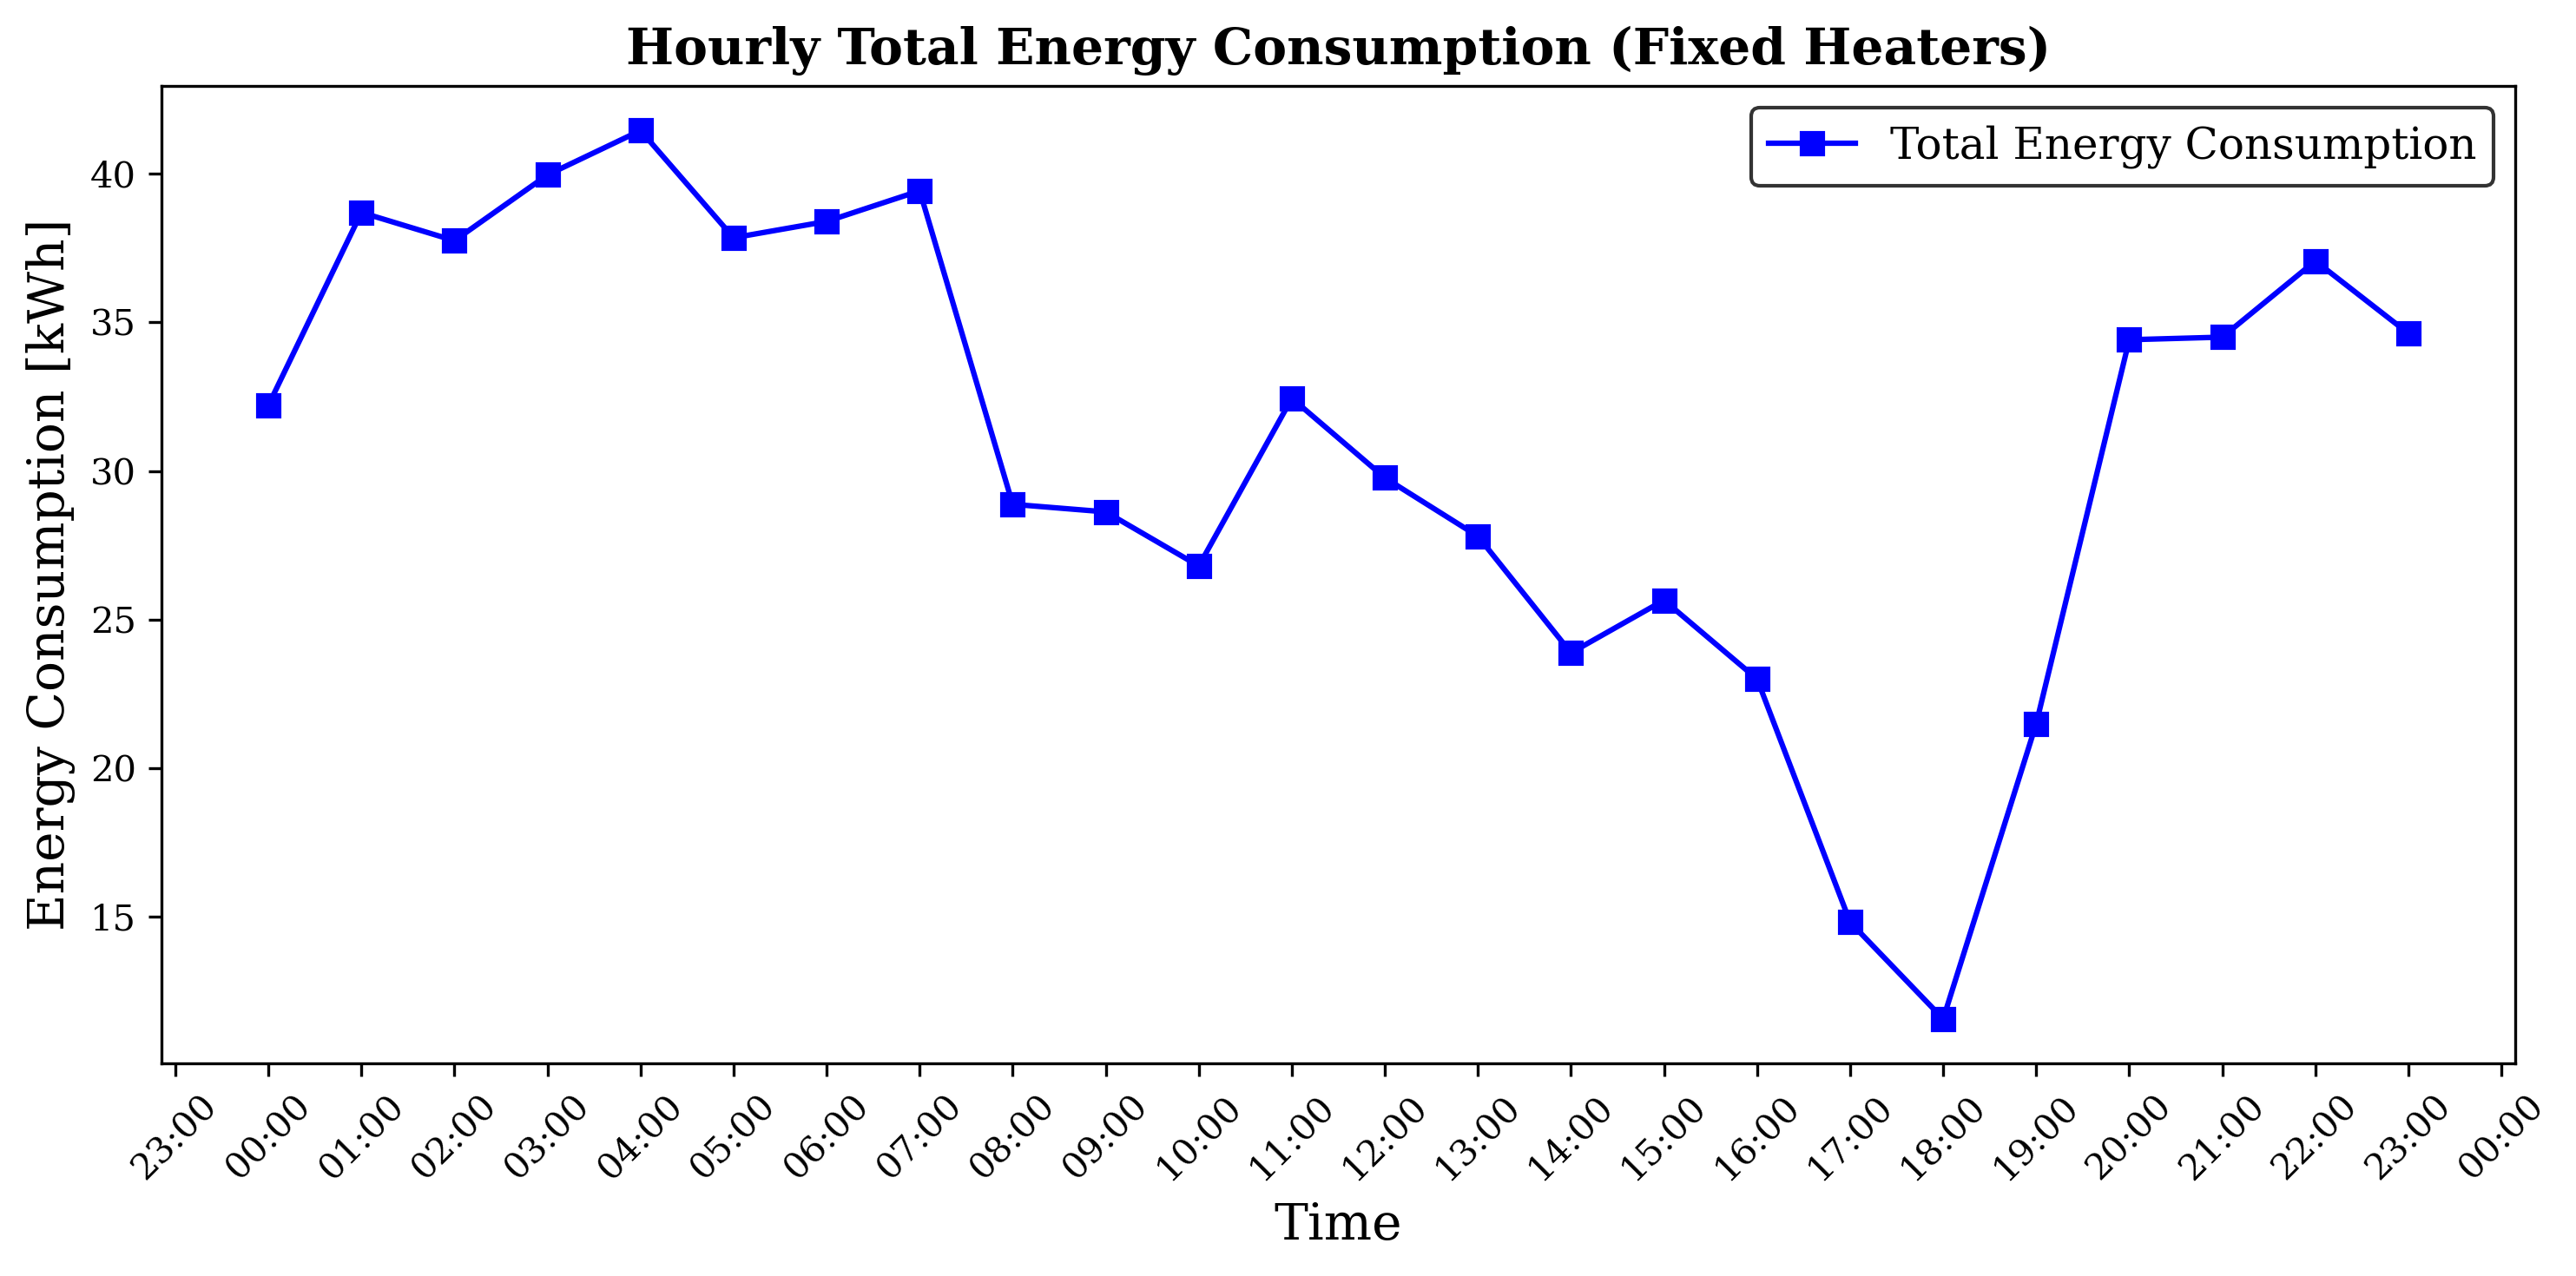

In [11]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(fixed_elec_df["datetime"], 
        fixed_elec_df["total_elec"], 
        marker="s", 
        linestyle="-", 
        color="b", 
        label="Total Energy Consumption")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Energy Consumption [kWh]", fontsize=14)
ax.set_title("Hourly Total Energy Consumption (Fixed Heaters)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

---

#  Rules-based Control

## Simulate the Rules-based Control
This section simulates the **rules-based control** strategy for heater deployment in the greenhouse environment. 

Unlike the fixed heater deployment, this approach follows a predefined rule: heaters adjust their positions dynamically, moving toward the coldest zones to maintain optimal temperature distribution.

In [12]:
# Create an instance of the Greenhouse Environment
# 4 heaters
rb_env = GreenhouseEnv(start_month = 2, 
                    end_month = 2, 
                    start_day = 28,  
                    end_day = 28, 
                    start_hour = 1,  
                    num_width = 8, 
                    num_length = 8, 
                    num_heater = 4,  
                    init_action = [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0], 
                    init_position = [18, 21, 42, 45],    
                    init_reward = 0,    
                    model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
                    energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
                    epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
                    output_dir = "energyplus_data", 
                    output_prefix = "updated_sim_", 
                    modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
                    modified_idf_path = "energyplus_data/model_files/modified_model.idf"
                    )

# # 6 heaters
# rb_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 6, 
#                     init_action = [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 56, 63],
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# # 8 heaters
# rb_env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 8, 
#                     init_action = [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 40, 47, 56, 63], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# Initialize the environment and reset it to the initial state
observation = rb_env.reset()
terminated = False
truncated = False

# Run the environment for one episode
while not(terminated or truncated):
    # Take a step to the Rules-based in the environment
    observation, reward, terminated, _, _ = rb_env.step_move_to_lowest()

Reset the episode time: Month:2, Day:28, Hour:1
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
DataFrames saved to CSV successfully. 
--------
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
Roof height relative to wall: 0.85 m
Floo

## Air temperature

In [13]:
# Load and Read the CSV file
# rb_temp_df = pd.read_csv('energyplus_data/updated_sim_temp.csv')

# Pre-simulated 4 heaters
rb_temp_df = pd.read_csv('energyplus_data/rb_4h_15a_temp.csv')

# Pre-simulated 6 heaters
# rb_temp_df = pd.read_csv('energyplus_data/rb_6h_15a_temp.csv')

# Pre-simulated 8 heaters
# rb_temp_df = pd.read_csv('energyplus_data/rb_8h_15a_temp.csv')

# Display the raw data frame
# rb_temp_df.info()
# rb_temp_df.head()

# Parse the "Date/Time" column into datetime format (YYYY-MM-DD hh:mm:ss)
# Strip any leading/trailing spaces in the "Date/Time" column
rb_temp_df['Date/Time'] = rb_temp_df['Date/Time'].str.strip()

# Insert missing space between the date and time
rb_temp_df['Date/Time'] = rb_temp_df['Date/Time'].str.slice(0, 5) + ' ' + rb_temp_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
rb_temp_df['Adjusted Date/Time'] = rb_temp_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
rb_temp_df['datetime'] = pd.to_datetime('2023 ' + rb_temp_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# # Display the result data frame
# print(rb_temp_df[['Date/Time', 'Adjusted Date/Time', 'datetime']].head(24))

# Select columns containing specific strings
# Keywords to filter the columns
columns_of_interest = ['Zone Air Temperature',
                       'Heating Coil energy consumption', 
                       'Cooling Coil energy consumption'
                       ]

# Filter for columns containing any of the keywords
selected_columns = [col for col in rb_temp_df.columns if any(keyword in col for keyword in columns_of_interest)]

# Add the datetime column to the selected columns
selected_columns.insert(0, 'datetime')

# Create a new dataframe with the selected columns
rb_temp_df = rb_temp_df[selected_columns]
# rb_temp_df.info()
# rb_temp_df.head()

# Melt the data frame
# Melt the dataframe to long format for easier processing
rb_temp_df = rb_temp_df.melt(id_vars=['datetime'], 
                             var_name='zone', 
                             value_name='value'
                             )

# # Display the melted data frame
# rb_temp_df.head()

# Extract the zone column
# Clean the 'zone' column by removing prefixes
rb_temp_df['zone'] = rb_temp_df['zone'].str.replace('GREENHOUSE ZONE ', '', regex=False)

# Convert heating coil column names
rb_temp_df['zone'] = rb_temp_df['zone'].str.replace(r'COIL HEATING ELECTRIC (\d+):Heating Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'heating_coil_\1', regex=True)

# Convert cooling coil column names
rb_temp_df['zone'] = rb_temp_df['zone'].str.replace(r'COIL COOLING DX SINGLE SPEED (\d+):Cooling Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'cooling_coil_\1', regex=True)

# rb_temp_df['zone'].unique()
# rb_temp_df.info()
# rb_temp_df.head()

# Create the proper Rules-based policy data frame
# Filter out the rows containing specific strings
excluded_keywords = ['ROOF',
                     'heating_coil', 
                     'cooling_coil'
                     ]

# Using str.contains to filter rows and invert the selection (using ~ for negation)
mask = rb_temp_df['zone'].str.contains('|'.join(excluded_keywords), case=False)
rb_temp_df = rb_temp_df[~mask]

# Clean the "zone" column to only include patterns like ZONE_\d+_\d+
# Extract zones with the pattern and drop others
rb_temp_df.loc[:, 'zone'] = rb_temp_df.loc[:, 'zone'].str.extract(r'(ZONE_\d+_\d+)', expand=False)

# Create 'coordinate_x' and 'coordinate_y' columns from 'zone' column
# rb_temp_df['coordinate_x'] = rb_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
# rb_temp_df['coordinate_y'] = rb_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)
rb_temp_df['coordinate_y'] = rb_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
rb_temp_df['coordinate_x'] = rb_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)

# Rename the "value" column to "air_temp"
rb_temp_df = rb_temp_df.rename(columns={'value': 'air_temp'})

# Delete missing values (drop any rows with NaN values)
rb_temp_df = rb_temp_df.dropna(subset=['datetime', 'air_temp'])

# Reset the index of the dataframe
rb_temp_df = rb_temp_df.reset_index(drop=True)

# Create the label column
rb_temp_df['type'] = 'Rules-based'

# Display the final dataframe
rb_temp_df.info()
rb_temp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      1536 non-null   datetime64[ns]
 1   zone          1536 non-null   object        
 2   air_temp      1536 non-null   float64       
 3   coordinate_y  1536 non-null   int32         
 4   coordinate_x  1536 non-null   int32         
 5   type          1536 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 60.1+ KB


,datetime,zone,air_temp,coordinate_y,coordinate_x,type
0,2023-02-28 00:00:00,ZONE_0_0,15.285581,0,0,Rules-based
1,2023-02-28 01:00:00,ZONE_0_0,19.000269,0,0,Rules-based
2,2023-02-28 02:00:00,ZONE_0_0,14.496319,0,0,Rules-based
3,2023-02-28 03:00:00,ZONE_0_0,18.997541,0,0,Rules-based
4,2023-02-28 04:00:00,ZONE_0_0,14.186477,0,0,Rules-based


### Mean hourly temperature deviation and average temperature
* Mean hourly temperature deviation [Celsius]: `avg_hourly_std_temp`
* Mean hourly temperatuer averages [Celsius]: `avg_hourly_avg_temp`

In [14]:
# Group by "datetime" and calculate standard deviation and average temperature
hourly_df = rb_temp_df.groupby('datetime')["air_temp"].agg(hourly_std_temp='std', hourly_avg_temp='mean').reset_index()

# Step 2: Add a "month" column for grouping by month
hourly_df['month'] = hourly_df['datetime'].dt.month

# Group by "month" and calculate the average of hourly standard deviations and averages
monthly_df = hourly_df.groupby('month').agg(avg_hourly_std_temp=('hourly_std_temp', 'mean'), avg_hourly_avg_temp=('hourly_avg_temp', 'mean')).reset_index()
monthly_df = monthly_df.round({'avg_hourly_std_temp': 2, 
                               'avg_hourly_avg_temp': 2})

# Show the data frame
monthly_df

,month,avg_hourly_std_temp,avg_hourly_avg_temp
0,2,0.77,17.14


In [15]:
# Visualize the hourly heatmap of the specific date
# Filter data for the specific time range (1 hour, from 00:00:00 to 23:00:00)
start_time = '2023-02-28 00:00:00'
end_time = '2023-02-28 23:00:00'
time_range_df = rb_temp_df[(rb_temp_df['datetime'] >= start_time) & (rb_temp_df['datetime'] <= end_time)]

# Get the unique time steps
unique_times = time_range_df['datetime'].drop_duplicates().sort_values()

# Create a subplot with 1 row and 12 columns (tighter layout)
fig = make_subplots(
    rows=1, cols=len(unique_times),  # 1 row and 12 columns for 12 time steps
    shared_yaxes=True,               # Share y-axis across subplots
    horizontal_spacing=0.005,        # Minimize space between subplots (tight layout)
    subplot_titles=[f'{str(time)[11:16]}' for time in unique_times]  # Short titles (only time)
)

# Plot each time step in a separate column (heatmap)
for i, time in enumerate(unique_times, start=1):
    # Filter data for the current time step
    time_data = time_range_df[time_range_df['datetime'] == time]

    # Create a heatmap for this time step
    heatmap = go.Heatmap(
        z=time_data['air_temp'],        # Values for the heatmap
        x=time_data['coordinate_x'],    # X-axis: coordinate_x
        y=time_data['coordinate_y'],    # Y-axis: coordinate_y
        colorscale='OrRd',               # Use the 'Hot' colorscale
        showscale=False,
        colorbar=dict(title=r'Air Temp (C)'),    # Add cololbar title
        zmin=14,
        zmax=20
    )
    
    # Add this heatmap to the corresponding subplot (1 row, multiple columns)
    fig.add_trace(heatmap, row=1, col=i)

# Update layout to have shared color scale, adjust title, and x/y axis labels
fig.update_layout(
    title='Air Temperature Heatmap (2023-02-28 00:00:00 to 2023-02-28 23:00:00)',
    xaxis_title='Length (meter)',
    yaxis_title='Width (meter)',
    height=400,  # Compact height for a tighter layout
    width=3700,  # Total width for 12 columns
    font=dict(family="Computer Modern Sans Serif", size=14)
)

# Add a shared color scale to the right of the entire figure
fig.update_layout(coloraxis_colorbar=dict(
    title="Air Temp (C)",
    thicknessmode="pixels", 
    thickness=15,
    lenmode="pixels", 
    len=300,
    yanchor="middle", 
    y=0.5,
    ticks="outside",
))

# Display the plot
fig.show()

## Energy Consumption

In [16]:
# Load the CSV file
# rb_elec_df = pd.read_csv('energyplus_data/updated_sim_elec.csv')

# Pre-simulated 4 heaters
rb_elec_df = pd.read_csv('energyplus_data/rb_4h_15a_elec.csv')

# Pre-simulated 6 heaters
# rb_elec_df = pd.read_csv('energyplus_data/rb_6h_15a_elec.csv')

# Pre-simulated 8 heaters
# rb_elec_df = pd.read_csv('energyplus_data/rb_8h_15a_elec.csv')

# Rename the columns
rb_elec_df.rename(columns={
    rb_elec_df.columns[1]: "elec_rate_h1",
    rb_elec_df.columns[2]: "elec_rate_h2",
    rb_elec_df.columns[3]: "elec_rate_h3",
    rb_elec_df.columns[4]: "elec_rate_h4",
    # rb_elec_df.columns[5]: "elec_rate_h5",
    # rb_elec_df.columns[6]: "elec_rate_h6",
    # rb_elec_df.columns[7]: "elec_rate_h7",
    # rb_elec_df.columns[8]: "elec_rate_h8"
}, inplace=True)

# Convert the unit from Watt-hour (Wh) to kiloWatt-hour (kWh)
rb_elec_df.iloc[:, 1:] = rb_elec_df.iloc[:, 1:].apply(lambda x: x/1000)

# Format energy consumption columns decimal places
rb_elec_df.iloc[:, 1:] = rb_elec_df.iloc[:, 1:].round(4)

# # Display thhe raw data frame
# rb_elec_df.info()
# rb_elec_df.head()

# Process the electricity data frame
# Strip any leading/trailing spaces in the "Date/Time" column
rb_elec_df['Date/Time'] = rb_elec_df['Date/Time'].str.strip()

# Insert missing space between the date and time
rb_elec_df['Date/Time'] = rb_elec_df['Date/Time'].str.slice(0, 5) + ' ' + rb_elec_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
rb_elec_df['Adjusted Date/Time'] = rb_elec_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
rb_elec_df['datetime'] = pd.to_datetime('2023 ' + rb_elec_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# Select only relevant column
# # 4 heaters
rb_elec_df = rb_elec_df.iloc[:, [6, 1, 2, 3, 4]]
# # 6 heaters
# rb_elec_df = rb_elec_df.iloc[:, [8, 1, 2, 3, 4, 5, 6]]
# 8 heaters
# rb_elec_df = rb_elec_df.iloc[:, [10, 1, 2, 3, 4, 5, 6, 7, 8]]

# # Create the total energy consumption of all heater columns
# # 4 heaters
rb_elec_df["total_elec"] = rb_elec_df.iloc[:, 1:5].sum(axis=1)
# # 6 heaters
# rb_elec_df["total_elec"] = rb_elec_df.iloc[:, 1:7].sum(axis=1)
# # 8 heaters
# rb_elec_df["total_elec"] = rb_elec_df.iloc[:, 1:9].sum(axis=1)

# Create the label column
rb_elec_df['type'] = 'Rules-based'

# Display the final data frame
rb_elec_df.info()
rb_elec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      24 non-null     datetime64[ns]
 1   elec_rate_h1  24 non-null     float64       
 2   elec_rate_h2  24 non-null     float64       
 3   elec_rate_h3  24 non-null     float64       
 4   elec_rate_h4  24 non-null     float64       
 5   total_elec    24 non-null     float64       
 6   type          24 non-null     object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.4+ KB


,datetime,elec_rate_h1,elec_rate_h2,elec_rate_h3,elec_rate_h4,total_elec,type
0,2023-02-28 00:00:00,7.7210,8.2198,7.8868,8.3825,32.2101,Rules-based
1,2023-02-28 01:00:00,9.7139,10.1891,9.8334,10.2998,40.0362,Rules-based
2,2023-02-28 02:00:00,9.9579,9.9711,9.8011,9.8534,39.5835,Rules-based
3,2023-02-28 03:00:00,10.1453,10.3848,10.1835,10.4187,41.1323,Rules-based
4,2023-02-28 04:00:00,10.0332,10.0388,9.9278,9.9582,39.9580,Rules-based


### Total energy consumption [kiloWatt-hour]

In [17]:
# Calculate the total energy consumption
total_electricity = rb_elec_df["total_elec"].sum().round(2)

print(f"Total heating energy consumption: {total_electricity} kiloWatt-hour")

Total heating energy consumption: 882.63 kiloWatt-hour


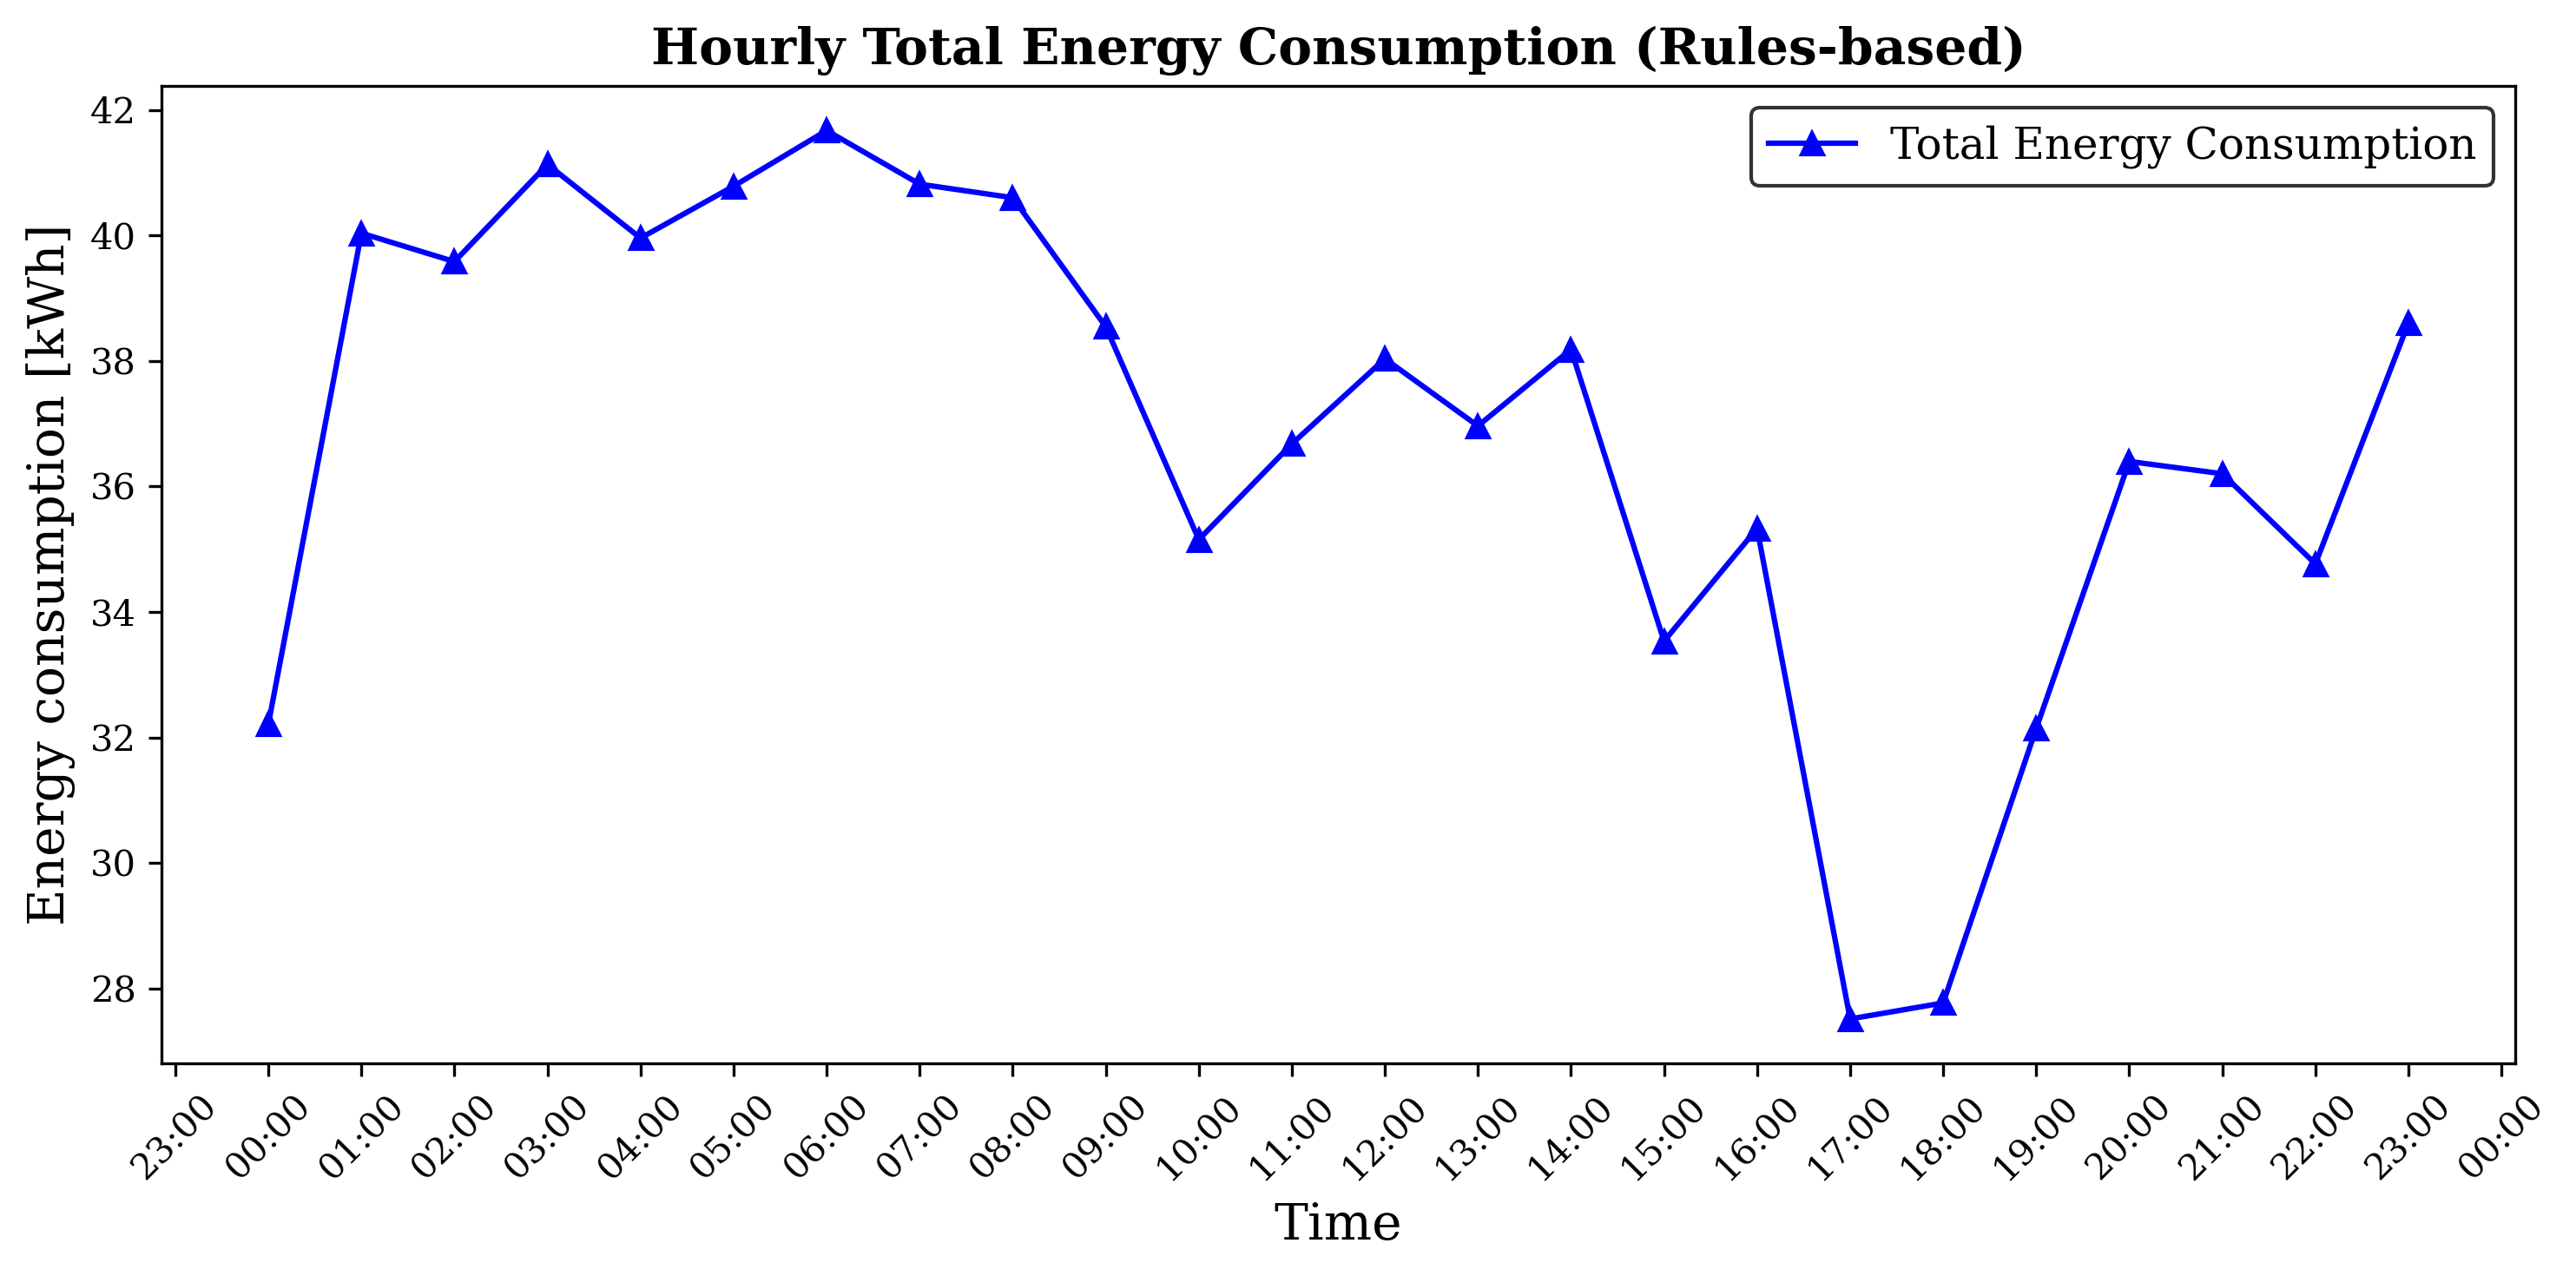

In [18]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), 
                       dpi=300)
ax.plot(rb_elec_df["datetime"], 
        rb_elec_df["total_elec"], 
        marker="^", 
        linestyle="-", 
        color="b", 
        label="Total Energy Consumption")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Energy consumption [kWh]", fontsize=14)
ax.set_title("Hourly Total Energy Consumption (Rules-based)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

---

# DRL model

## Simulate the DRL model
This section evaluates the **Deep Reinforcement Learning (DRL) model** for adaptive heater control in the greenhouse environment. 

Unlike fixed heater deployment and rules-based control, the DRL model dynamically adjusts heater positions and power settings based on learned policies to optimize energy efficiency and temperature distribution.

In [19]:
# Evaluate the Trained Agent
# Initialize the environment
# 4 heaters
env = GreenhouseEnv(start_month = 2, 
                    end_month = 2, 
                    start_day = 28,  
                    end_day = 28, 
                    start_hour = 1,  
                    num_width = 8, 
                    num_length = 8, 
                    num_heater = 4,  
                    init_action = [0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0], 
                    # init_position = [18, 21, 42, 45], 
                    init_position = [0, 7, 56, 63], 
                    init_reward = 0,    
                    model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
                    energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
                    epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
                    output_dir = "energyplus_data", 
                    output_prefix = "updated_sim_", 
                    modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
                    modified_idf_path = "energyplus_data/model_files/modified_model.idf"
                    )

# # 6 heaters
# env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 6, 
#                     init_action = [0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     # init_position = [9, 14, 20, 43, 49, 54],   
#                     init_position = [0, 7, 24, 31, 56, 63],
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# # 8 heaters
# env = GreenhouseEnv(start_month = 2, 
#                     end_month = 2, 
#                     start_day = 28,  
#                     end_day = 28, 
#                     start_hour = 1,  
#                     num_width = 8, 
#                     num_length = 8, 
#                     num_heater = 8, 
#                     init_action = [0, 0, 0, 0, 0, 0, 0, 0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0], 
#                     init_position = [0, 7, 24, 31, 40, 47, 56, 63], 
#                     init_reward = 0,    
#                     model_path = "energyplus_data/model_files/greenhouse_triangle.osm", 
#                     energyplus_exe_path = r"C:\EnergyPlusV24-2-0\energyplus.exe", 
#                     epw_file_path = "datasets/Rotterdam_the_Hague_2023.epw", 
#                     output_dir = "energyplus_data", 
#                     output_prefix = "updated_sim_", 
#                     modified_osm_path = "energyplus_data/model_files/modified_model.osm",    
#                     modified_idf_path = "energyplus_data/model_files/modified_model.idf"
#                     )

# Reload the trained model
# trained_model = PPO.load("ppo_model", env=env)

# Trained model for 4 heaters
trained_model = PPO.load("ppo_model_4heater", env=env)

# # Trained model for 6 heaters
# trained_model = PPO.load("ppo_model_6heater", env=env)

# # Trained model for 8 heaters
# trained_model = PPO.load("ppo_model_8heater", env=env)

# Get the initial observation (should be: [0.0] for the starting position).
obs, info = env.reset()
terminated = False
truncated = False

# Play episodes
while not (terminated or truncated):
    # Compute a single action, given the current observation from the environment.
    action, _ = trained_model.predict(obs, deterministic=False)
    
    # Apply the computed action in the environment.
    obs, reward, terminated, truncated, info = env.step(action)

c:\Users\ratht\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning:

Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_function_setstate' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\ratht\\anaconda3\\Lib\\site-packages\\cloudpickle\\cloudpickle.py'>

c:\Users\ratht\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning:

Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_function_setstate' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\ratht\\anaconda3\\Lib\\site-packages\\cloudpickle\\cloudpickle.py'>



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset the episode time: Month:2, Day:28, Hour:1
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
DataFrames saved to CSV successfully. 
--------
Movement action (mini-step): [3, 0, 1, 2], Energy action (mini-step): [18.0, 17.0, 19.0, 17.0]
Movement action (mini-step): [1, 2, 1, 2], Energy action (mini-step): [17.0, 17.0, 17.0, 18.0]
Movement action (mini-step): [3, 3, 1, 4], Energy action (mini-step): [17.0, 17.0, 17.0, 19.0]
Movement action (mini-step): [1, 2, 0, 1], Energy action (mini-step): [17.0, 18.0, 17.0, 17.0]
Movement action (main-step): [3, 3, 1, 1], Energy action (main-step): [17.0, 19.0, 17.0, 19.0]
Roof height relative to wall: 0.85 m
Floor area: 1024 m²
EnergyPlus simulation completed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Movement action (mini-step): [2, 3, 0, 2], Energy action (mini-step)

## Air temperature

In [20]:
# Load and Read the CSV file
# drl_temp_df = pd.read_csv('energyplus_data/updated_sim_temp.csv')

# Pre-simulated 4 heaters
drl_temp_df = pd.read_csv('energyplus_data/drl_4h_15a_3rew_temp.csv')

# Pre-simulated 6 heaters
# drl_temp_df = pd.read_csv('energyplus_data/drl_6h_15a_3rew_temp.csv')

# Pre-simulated 8 heaters
# drl_temp_df = pd.read_csv('energyplus_data/drl_8h_15a_3rew_temp.csv')

# Display the raw data frame
# drl_temp_df.info()
# drl_temp_df.head()

# Parse the "Date/Time" column into datetime format (YYYY-MM-DD hh:mm:ss)
# Strip any leading/trailing spaces in the "Date/Time" column
drl_temp_df['Date/Time'] = drl_temp_df['Date/Time'].str.strip()

# Insert missing space between the date and time
drl_temp_df['Date/Time'] = drl_temp_df['Date/Time'].str.slice(0, 5) + ' ' + drl_temp_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
drl_temp_df['Adjusted Date/Time'] = drl_temp_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
drl_temp_df['datetime'] = pd.to_datetime('2023 ' + drl_temp_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# # Display the result data frame
# print(drl_temp_df[['Date/Time', 'Adjusted Date/Time', 'datetime']].head(24))

# Select columns containing specific strings
# Keywords to filter the columns
columns_of_interest = ['Zone Air Temperature',
                       'Heating Coil energy consumption', 
                       'Cooling Coil energy consumption'
                       ]

# filter for columns containing any of the keywords
selected_columns = [col for col in drl_temp_df.columns if any(keyword in col for keyword in columns_of_interest)]

# Add the datetime column to the selected columns
selected_columns.insert(0, 'datetime')

# Create a new dataframe with the selected columns
drl_temp_df = drl_temp_df[selected_columns]
# drl_temp_df.info()
# drl_temp_df.head()

# melt the data frame
# melt the dataframe to long format for easier processing
drl_temp_df = drl_temp_df.melt(id_vars=['datetime'], 
                             var_name='zone', 
                             value_name='value'
                             )

# # Display the melted data frame
# drl_temp_df.head()

# Extract the zone column
# Clean the 'zone' column by removing prefixes
drl_temp_df['zone'] = drl_temp_df['zone'].str.replace('GREENHOUSE ZONE ', '', regex=False)

# Convert heating coil column names
drl_temp_df['zone'] = drl_temp_df['zone'].str.replace(r'COIL HEATING ELECTRIC (\d+):Heating Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'heating_coil_\1', regex=True)

# Convert cooling coil column names
drl_temp_df['zone'] = drl_temp_df['zone'].str.replace(r'COIL COOLING DX SINGLE SPEED (\d+):Cooling Coil energy consumption \[W\]\(TimeStep\)', 
                                                   r'cooling_coil_\1', regex=True)

# drl_temp_df['zone'].unique()
# drl_temp_df.info()
# drl_temp_df.head()

# Create the proper DRL data frame
# filter out the rows containing specific strings
excluded_keywords = ['ROOF',
                     'heating_coil', 
                     'cooling_coil'
                     ]

# Using str.contains to filter rows and invert the selection (using ~ for negation)
mask = drl_temp_df['zone'].str.contains('|'.join(excluded_keywords), case=False)
drl_temp_df = drl_temp_df[~mask]

# Clean the "zone" column to only include patterns like ZONE_\d+_\d+
# Extract zones with the pattern and drop others
drl_temp_df.loc[:, 'zone'] = drl_temp_df.loc[:, 'zone'].str.extract(r'(ZONE_\d+_\d+)', expand=False)

# Create 'coordinate_x' and 'coordinate_y' columns from 'zone' column
# drl_temp_df['coordinate_x'] = drl_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
# drl_temp_df['coordinate_y'] = drl_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)
drl_temp_df['coordinate_y'] = drl_temp_df.loc[:, 'zone'].str.extract(r'ZONE_(\d+)').astype(int)
drl_temp_df['coordinate_x'] = drl_temp_df.loc[:, 'zone'].str.extract(r'ZONE_\d+_(\d+)').astype(int)

# Rename the "value" column to "air_temp"
drl_temp_df = drl_temp_df.rename(columns={'value': 'air_temp'})

# Delete missing values (drop any rows with NaN values)
drl_temp_df = drl_temp_df.dropna(subset=['datetime', 'air_temp'])

# Reset the index of the dataframe
drl_temp_df = drl_temp_df.reset_index(drop=True)

# Create the label column
drl_temp_df['type'] = 'DRL'

# Display the final dataframe
drl_temp_df.info()
drl_temp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      1536 non-null   datetime64[ns]
 1   zone          1536 non-null   object        
 2   air_temp      1536 non-null   float64       
 3   coordinate_y  1536 non-null   int32         
 4   coordinate_x  1536 non-null   int32         
 5   type          1536 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 60.1+ KB


,datetime,zone,air_temp,coordinate_y,coordinate_x,type
0,2023-02-28 00:00:00,ZONE_0_0,19.005629,0,0,DRL
1,2023-02-28 01:00:00,ZONE_0_0,16.276028,0,0,DRL
2,2023-02-28 02:00:00,ZONE_0_0,15.209137,0,0,DRL
3,2023-02-28 03:00:00,ZONE_0_0,14.398458,0,0,DRL
4,2023-02-28 04:00:00,ZONE_0_0,14.351415,0,0,DRL


### Mean hourly temperature deviation and average temperature
* Mean hourly temperature deviation [Celsius]: `avg_hourly_std_temp`
* Mean hourly temperatuer averages [Celsius]: `avg_hourly_avg_temp`

In [21]:
# Group by "datetime" and calculate standard deviation and average temperature
hourly_df = drl_temp_df.groupby('datetime')["air_temp"].agg(hourly_std_temp='std', hourly_avg_temp='mean').reset_index()

# Step 2: Add a "month" column for grouping by month
hourly_df['month'] = hourly_df['datetime'].dt.month

# Group by "month" and calculate the average of hourly standard deviations and averages
monthly_df = hourly_df.groupby('month').agg(avg_hourly_std_temp=('hourly_std_temp', 'mean'), avg_hourly_avg_temp=('hourly_avg_temp', 'mean')).reset_index()
monthly_df = monthly_df.round({'avg_hourly_std_temp': 2, 
                               'avg_hourly_avg_temp': 2})

# Show the data frame
monthly_df

,month,avg_hourly_std_temp,avg_hourly_avg_temp
0,2,0.73,17.33


In [22]:
# Visualize the hourly heatmap of the specific date
# filter data for the specific time range (1 hour, from 00:00:00 to 23:00:00)
start_time = '2023-02-28 00:00:00'
end_time = '2023-02-28 23:00:00'
time_range_df = drl_temp_df[(drl_temp_df['datetime'] >= start_time) & (drl_temp_df['datetime'] <= end_time)]

# Get the unique time steps
unique_times = time_range_df['datetime'].drop_duplicates().sort_values()

# Create a subplot with 1 row and 12 columns (tighter layout)
fig = make_subplots(
    rows=1, cols=len(unique_times),  # 1 row and 12 columns for 12 time steps
    shared_yaxes=True,               # Share y-axis across subplots
    horizontal_spacing=0.005,        # Minimize space between subplots (tight layout)
    subplot_titles=[f'{str(time)[11:16]}' for time in unique_times]  # Short titles (only time)
)

# Plot each time step in a separate column (heatmap)
for i, time in enumerate(unique_times, start=1):
    # filter data for the current time step
    time_data = time_range_df[time_range_df['datetime'] == time]

    # Create a heatmap for this time step
    heatmap = go.Heatmap(
        z=time_data['air_temp'],        # Values for the heatmap
        x=time_data['coordinate_x'],    # X-axis: coordinate_x
        y=time_data['coordinate_y'],    # Y-axis: coordinate_y
        colorscale='OrRd',               # Use the 'Hot' colorscale
        showscale=False,
        colorbar=dict(title=r'Air Temp (C)'),    # Add colorbar title
        zmin=14,
        zmax=20
    )
    
    # Add this heatmap to the corresponding subplot (1 row, multiple columns)
    fig.add_trace(heatmap, row=1, col=i)

# Update layout to have shared color scale, adjust title, and x/y axis labels
fig.update_layout(
    title='Air Temperature Heatmap (2023-02-28 00:00:00 to 2023-02-28 23:00:00)',
    xaxis_title='Length (meter)',
    yaxis_title='Width (meter)',
    height=400,  # Compact height for a tighter layout
    width=3700,  # Total width for 12 columns
    font=dict(family="Computer Modern Sans Serif", size=14)
)

# Add a shared color scale to the right of the entire figure
fig.update_layout(coloraxis_colorbar=dict(
    title="Air Temp (C)",
    thicknessmode="pixels", 
    thickness=15,
    lenmode="pixels", 
    len=300,
    yanchor="middle", 
    y=0.5,
    ticks="outside",
))

# Display the plot
fig.show()

## Energy Consumption

In [23]:
# Load the CSV file
# drl_elec_df = pd.read_csv('energyplus_data/updated_sim_elec.csv')

# Pre-simulated 4 heaters
drl_elec_df = pd.read_csv('energyplus_data/drl_4h_15a_3rew_elec.csv')

# Pre-simulated 6 heaters
# drl_elec_df = pd.read_csv('energyplus_data/drl_6h_15a_3rew_elec.csv')

# Pre-simulated 8 heaters
# drl_elec_df = pd.read_csv('energyplus_data/drl_8h_15a_3rew_elec.csv')

# Rename the columns
drl_elec_df.rename(columns={
    drl_elec_df.columns[1]: "elec_rate_h1",
    drl_elec_df.columns[2]: "elec_rate_h2",
    drl_elec_df.columns[3]: "elec_rate_h3",
    drl_elec_df.columns[4]: "elec_rate_h4",
    # drl_elec_df.columns[5]: "elec_rate_h5",
    # drl_elec_df.columns[6]: "elec_rate_h6",
    # drl_elec_df.columns[7]: "elec_rate_h7",
    # drl_elec_df.columns[8]: "elec_rate_h8"
}, inplace=True)

# Convert the unit from Watt-hour (Wh) to kiloWatt-hour (kWh)
drl_elec_df.iloc[:, 1:] = drl_elec_df.iloc[:, 1:].apply(lambda x: x/1000)

# Format energy consumption columns decimal places
drl_elec_df.iloc[:, 1:] = drl_elec_df.iloc[:, 1:].round(4)

# # Display thhe raw data frame
# drl_elec_df.info()
# drl_elec_df.head()

# Process the electricity data frame
# Strip any leading/trailing spaces in the "Date/Time" column
drl_elec_df['Date/Time'] = drl_elec_df['Date/Time'].str.strip()

# Insert missing space between the date and time
drl_elec_df['Date/Time'] = drl_elec_df['Date/Time'].str.slice(0, 5) + ' ' + drl_elec_df['Date/Time'].str.slice(5)

# Adjust the hour by reducing it by 1, handling "24:00:00" as "23:00:00"
def adjust_time(date_time_str):
    date, time = date_time_str.split()
    hour, minute, second = map(int, time.split(':'))
    
    # Adjust hour if needed
    if hour == 0:
        hour = 23
    else:
        hour -= 1

    adjusted_time = f"{hour:02}:{minute:02}:{second:02}"
    return f"{date} {adjusted_time}"

# Apply the adjustment function to each entry in the "Date/Time" column
drl_elec_df['Adjusted Date/Time'] = drl_elec_df['Date/Time'].apply(adjust_time)

# Prepend the placeholder year and convert to datetime
drl_elec_df['datetime'] = pd.to_datetime('2023 ' + drl_elec_df['Adjusted Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')

# Select only relevant column
# # 4 heaters
drl_elec_df = drl_elec_df.iloc[:, [6, 1, 2, 3, 4]]
# # 6 heaters
# drl_elec_df = drl_elec_df.iloc[:, [8, 1, 2, 3, 4, 5, 6]]
# 8 heaters
# drl_elec_df = drl_elec_df.iloc[:, [10, 1, 2, 3, 4, 5, 6, 7, 8]]

# Create the total energy consumption of all heater columns
# # 4 heaters
drl_elec_df["total_elec"] = drl_elec_df.iloc[:, 1:5].sum(axis=1)
# # 6 heaters
# drl_elec_df["total_elec"] = drl_elec_df.iloc[:, 1:7].sum(axis=1)
# 8 heaters
# drl_elec_df["total_elec"] = drl_elec_df.iloc[:, 1:9].sum(axis=1)

# Create the label column
drl_elec_df['type'] = 'DRL'

# Display the final data frame
drl_elec_df.info()
drl_elec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      24 non-null     datetime64[ns]
 1   elec_rate_h1  24 non-null     float64       
 2   elec_rate_h2  24 non-null     float64       
 3   elec_rate_h3  22 non-null     float64       
 4   elec_rate_h4  16 non-null     float64       
 5   total_elec    24 non-null     float64       
 6   type          24 non-null     object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.4+ KB


,datetime,elec_rate_h1,elec_rate_h2,elec_rate_h3,elec_rate_h4,total_elec,type
0,2023-02-28 00:00:00,9.4734,10.2722,9.7221,10.5143,39.9820,DRL
1,2023-02-28 01:00:00,3.3294,10.2993,6.3333,3.5709,23.5329,DRL
2,2023-02-28 02:00:00,4.9233,3.7084,10.1300,6.0255,24.7872,DRL
3,2023-02-28 03:00:00,9.2236,10.6517,5.2340,9.3874,34.4967,DRL
4,2023-02-28 04:00:00,10.5116,6.8320,6.4144,7.5969,31.3549,DRL


### Total energy consumption [kiloWatt-hour]

In [24]:
# Calculate the total energy consumption
total_electricity = drl_elec_df["total_elec"].sum().round(2)

print(f"Total heating energy consumption: {total_electricity} kiloWatt-hour")

Total heating energy consumption: 557.74 kiloWatt-hour


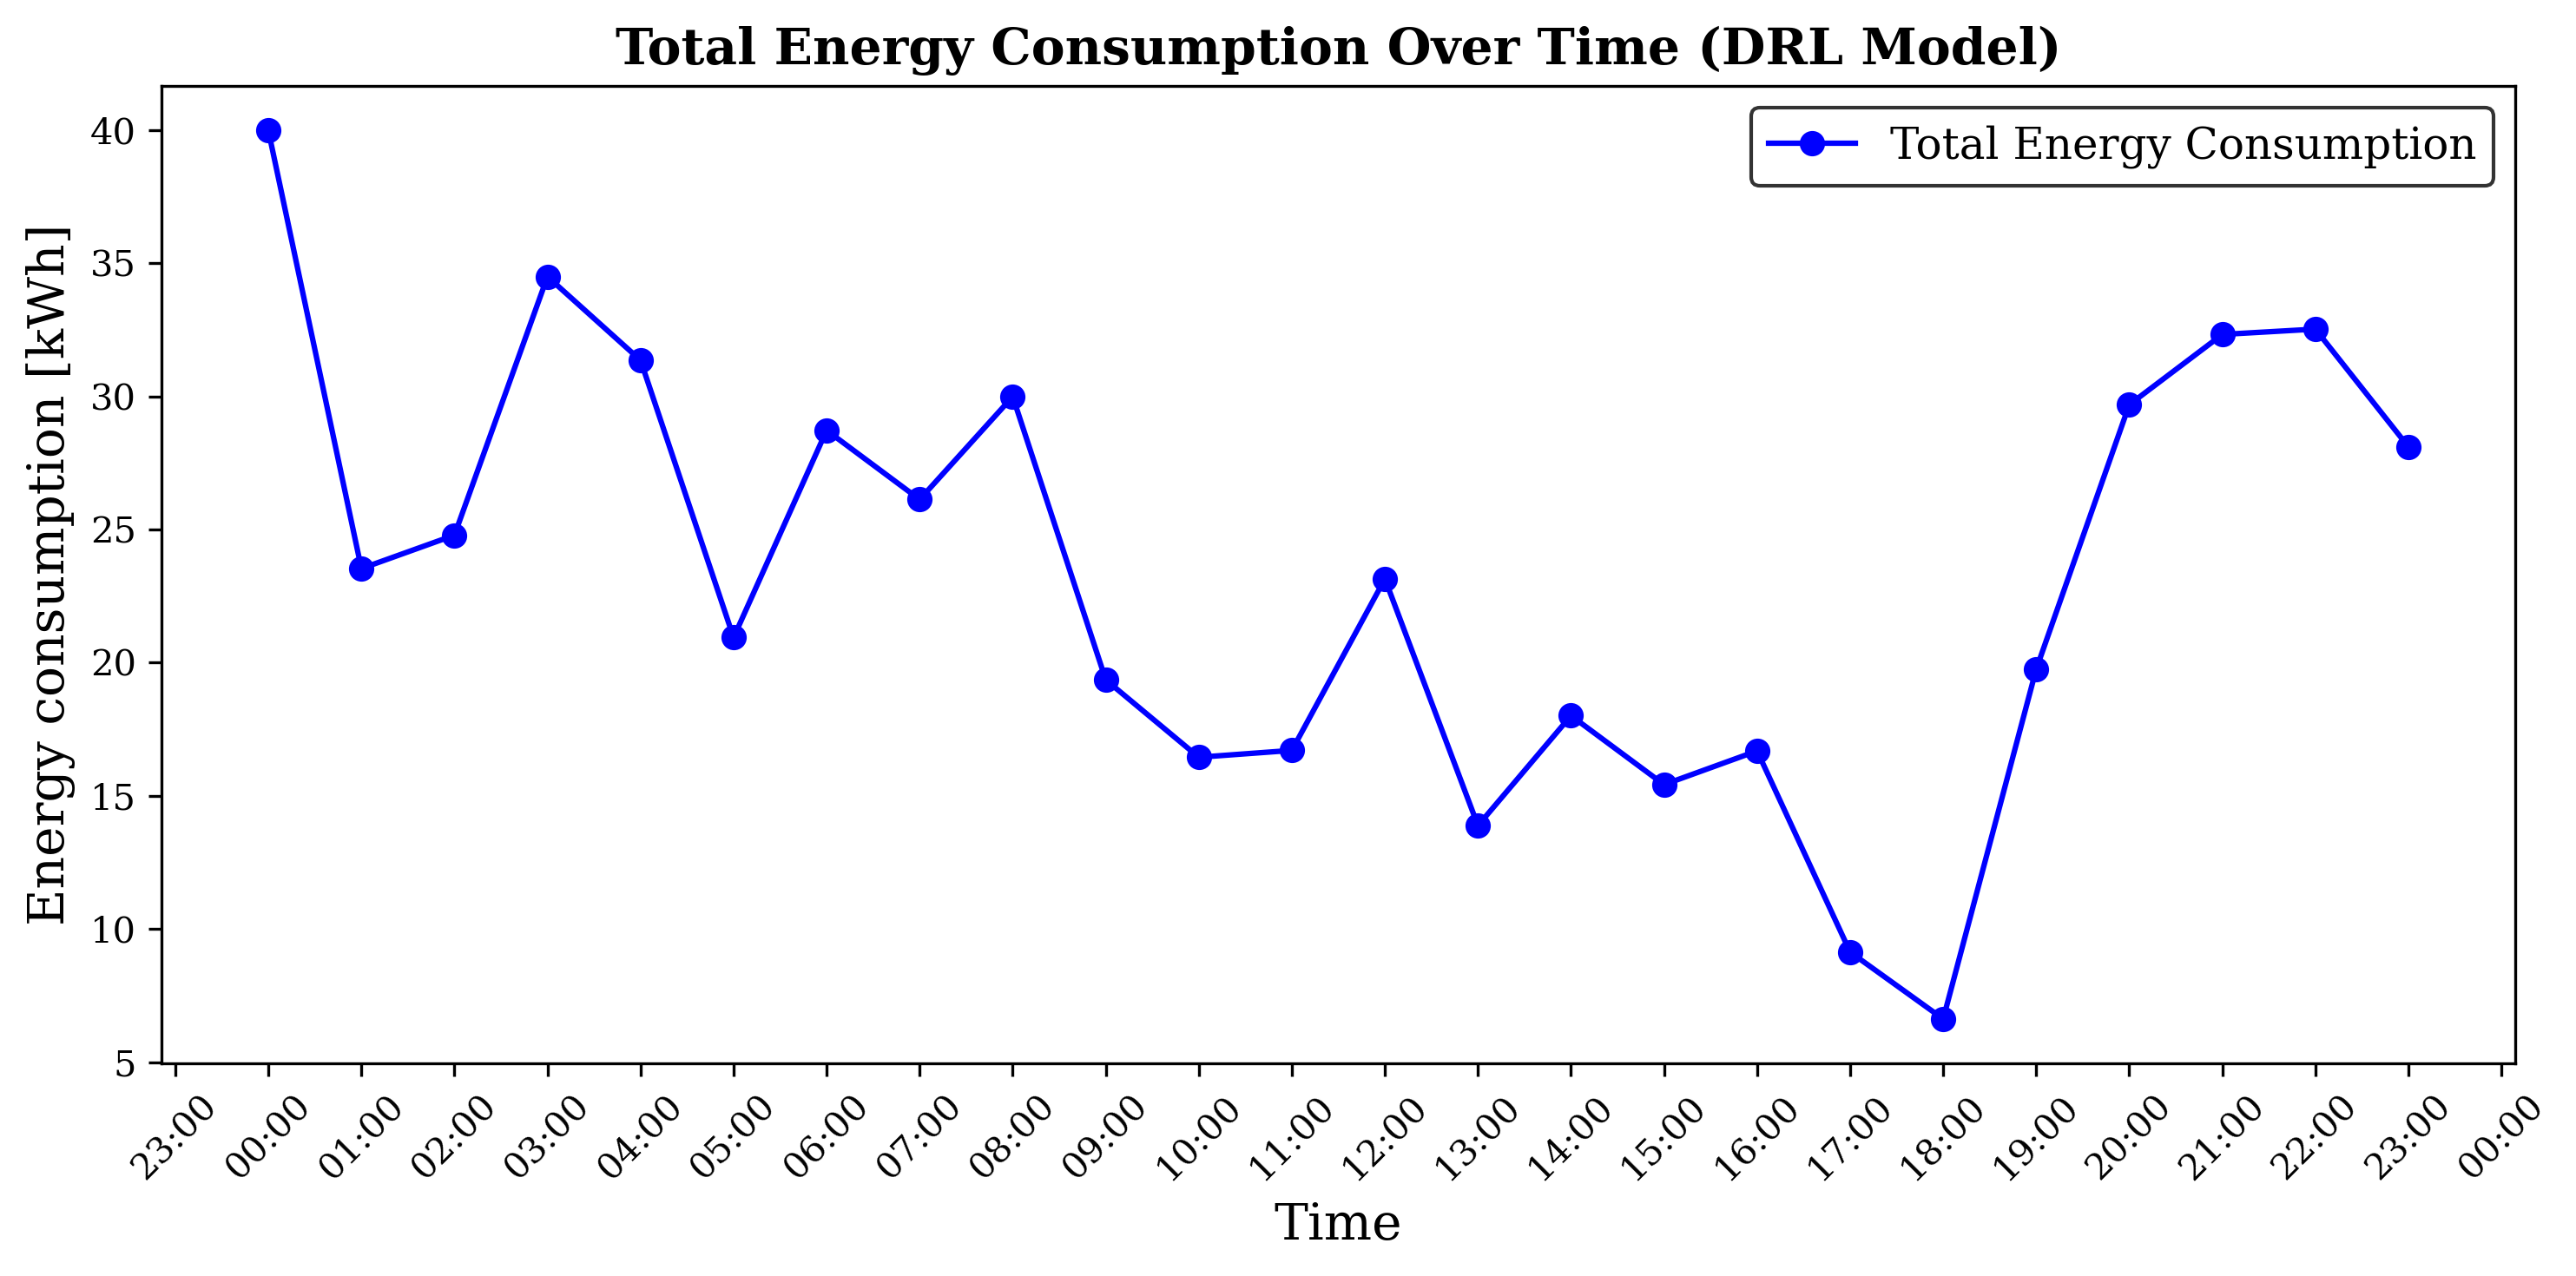

In [25]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), 
                       dpi=300)
ax.plot(drl_elec_df["datetime"], 
        drl_elec_df["total_elec"], 
        marker="o", 
        linestyle="-", 
        color="b", 
        label="Total Energy Consumption")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Energy consumption [kWh]", fontsize=14)
ax.set_title("Total Energy Consumption Over Time (DRL Model)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

# Reward

In [26]:
# Load the CSV file
# reward_df = pd.read_csv('energyplus_data/updated_sim_reward.csv')

# Pre-simulated 4 heaters
reward_df = pd.read_csv('energyplus_data/drl_4h_15a_3rew_reward.csv')

# Pre-simulated 6 heaters
# reward_df = pd.read_csv('energyplus_data/drl_6h_15a_3rew_reward.csv')

# Pre-simulated 8 heaters
# reward_df = pd.read_csv('energyplus_data/drl_8h_15a_3rew_reward.csv')

# Combine "2023" + Month + Day + Hour into a datetime column
reward_df['datetime'] = pd.to_datetime({
    'year': 2023,
    'month': reward_df['Month'],
    'day': reward_df['Day'],
    'hour': reward_df['Hour']
})

# Adjust the Hour column by subtracting 1
reward_df['datetime'] = reward_df['datetime'].apply(
    lambda dt: dt - pd.Timedelta(hours=1) if dt.hour < 24 else dt.replace(hour=23)
)

# Create cumulative reward column
reward_df['cumulative_reward'] = reward_df['Reward'].cumsum()

# Display the data frame
reward_df.info()
reward_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Month              24 non-null     int64         
 1   Day                24 non-null     int64         
 2   Hour               24 non-null     int64         
 3   Reward             24 non-null     float64       
 4   datetime           24 non-null     datetime64[ns]
 5   cumulative_reward  24 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.3 KB


,Month,Day,Hour,Reward,datetime,cumulative_reward
0,2,28,1,0.000000,2023-02-28 00:00:00,0.000000
1,2,28,2,3.497023,2023-02-28 01:00:00,3.497023
2,2,28,3,2.151746,2023-02-28 02:00:00,5.648770
3,2,28,4,2.019186,2023-02-28 03:00:00,7.667955
4,2,28,5,5.159004,2023-02-28 04:00:00,12.826960


## Total and cumulative reward

In [27]:
# Calculate the total reward
total_reward = reward_df['Reward'].sum()

# Print the total reward
print(f"Total Reward: {total_reward:.2f}")

Total Reward: 77.87


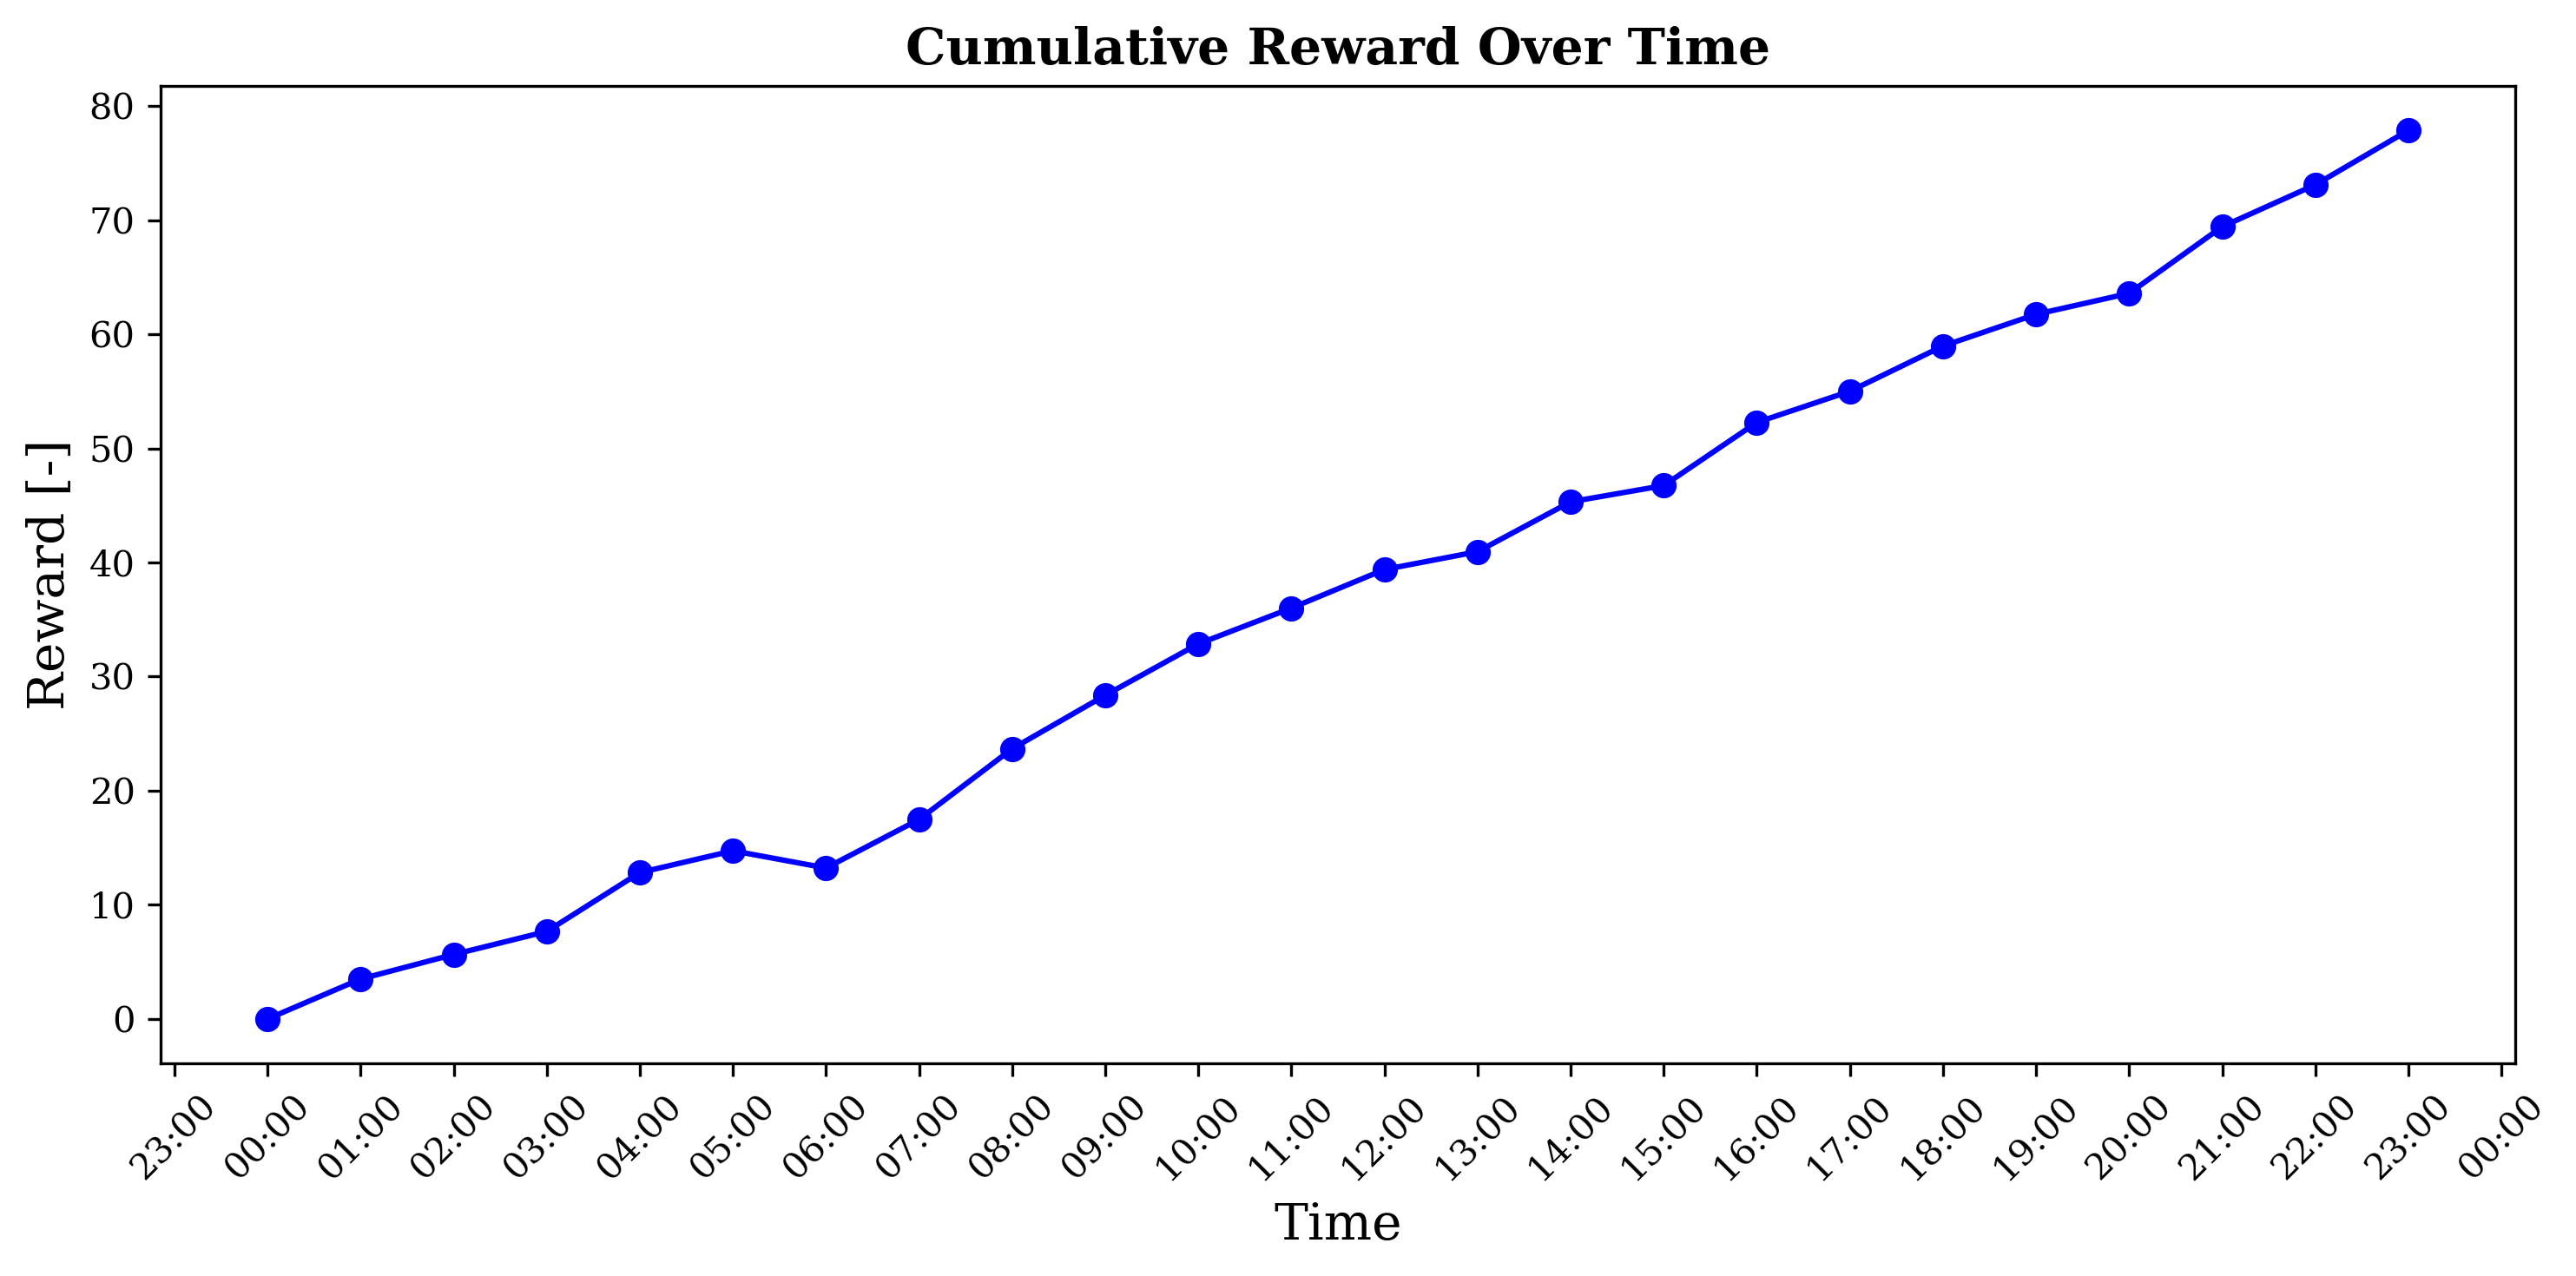

In [28]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), 
                       dpi=300)
ax.plot(reward_df["datetime"], 
        reward_df["cumulative_reward"], 
        marker="o", 
        linestyle="-", 
        color="b"
        )

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Reward [-]", fontsize=14)
ax.set_title("Cumulative Reward Over Time", fontsize=14, fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

---

# Model Performance Summary
1. Temperature standard deviation [C]
2. Temperature average [C]
3. Total energy consumption [kWh]

In [29]:
# Create the air temperature summary data frame
# Group by "datetime" and calculate standard deviation and average temperature
fixed_temp_sum_df = fixed_temp_df.groupby(["datetime", "type"]).agg(hourly_std_temp=('air_temp', 'std'), 
                                                                    hourly_avg_temp=('air_temp', 'mean')
                                                                    ).reset_index()

rb_temp_sum_df = rb_temp_df.groupby(["datetime", "type"]).agg(hourly_std_temp=('air_temp', 'std'), 
                                                                    hourly_avg_temp=('air_temp', 'mean')
                                                                    ).reset_index()

drl_temp_sum_df = drl_temp_df.groupby(["datetime", "type"]).agg(hourly_std_temp=('air_temp', 'std'), 
                                                                    hourly_avg_temp=('air_temp', 'mean')
                                                                    ).reset_index()

# Append the data frame
sum_temp_df = pd.concat([fixed_temp_sum_df, rb_temp_sum_df, drl_temp_sum_df], ignore_index=True)

# Save to the CSV file
sum_temp_df.to_csv("model_performance_4h.csv", index=False)
# sum_temp_df.to_csv("model_performance_6h.csv", index=False)
# sum_temp_df.to_csv("model_performance_8h.csv", index=False)

# Display the data frame
sum_temp_df.info()
sum_temp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         72 non-null     datetime64[ns]
 1   type             72 non-null     object        
 2   hourly_std_temp  72 non-null     float64       
 3   hourly_avg_temp  72 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.4+ KB


,datetime,type,hourly_std_temp,hourly_avg_temp
0,2023-02-28 00:00:00,Fixed Heaters,0.941829,16.748644
1,2023-02-28 01:00:00,Fixed Heaters,1.036672,16.478246
2,2023-02-28 02:00:00,Fixed Heaters,1.106890,16.351252
3,2023-02-28 03:00:00,Fixed Heaters,1.144965,16.242610
4,2023-02-28 04:00:00,Fixed Heaters,1.178344,16.174124


## Temperature Standard Deviation

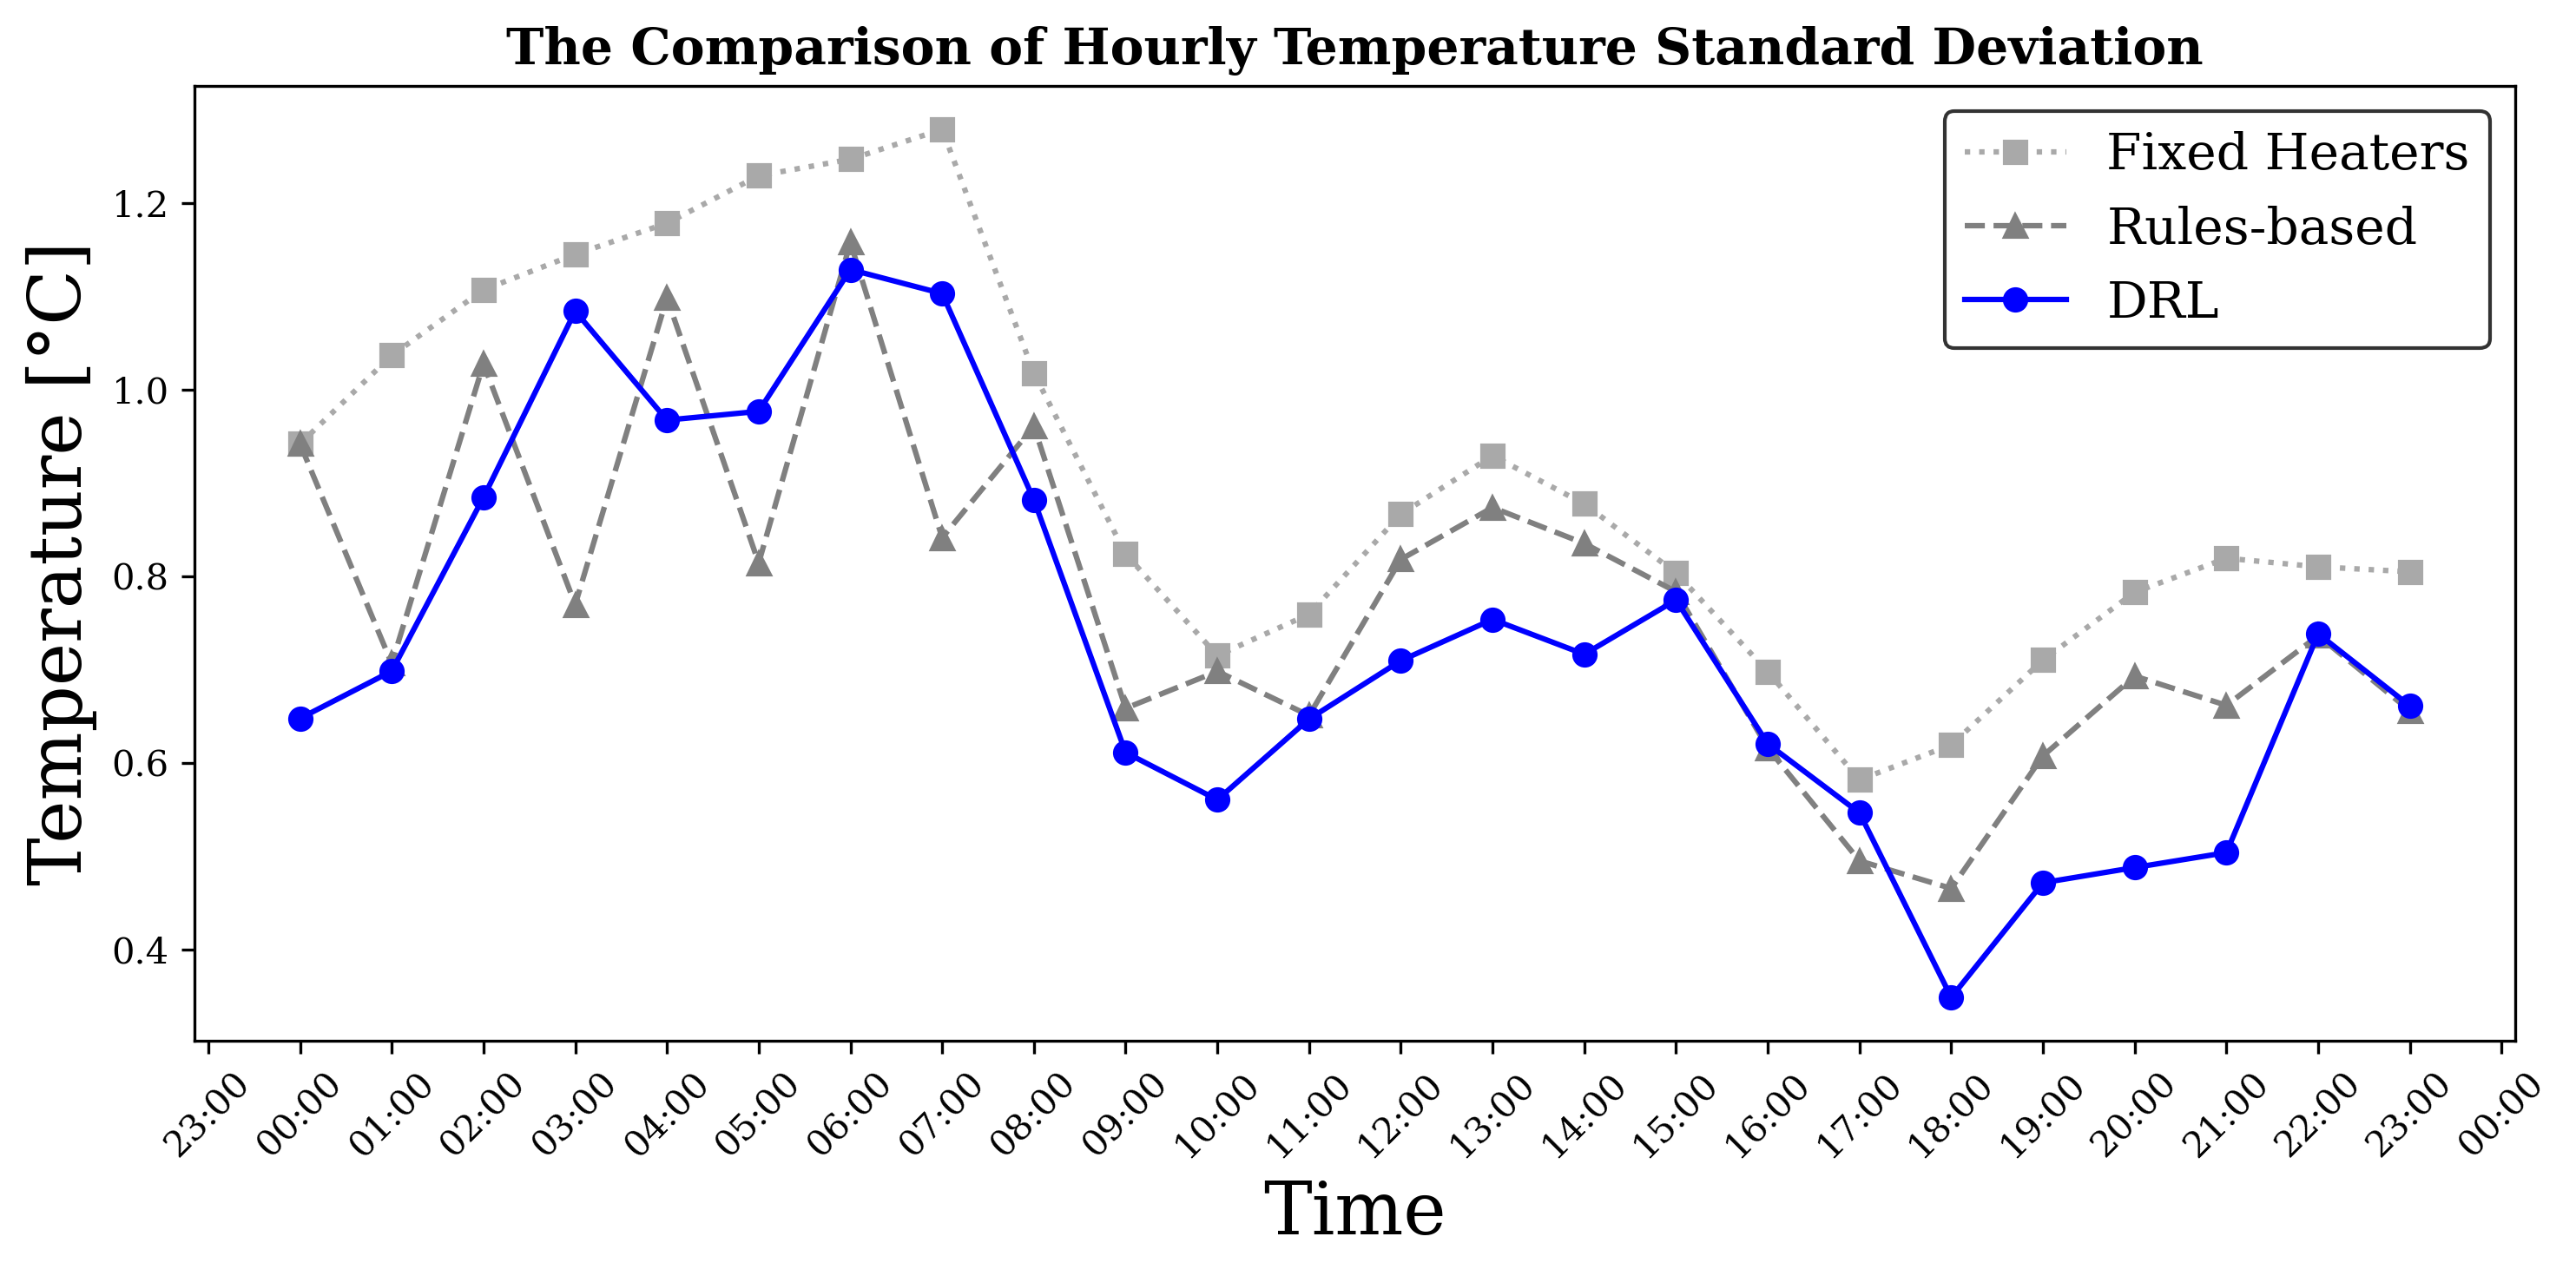

In [30]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Define marker, color, and linestyle mapping for specific types
style_map = {
    "DRL": ("o", "blue", "-"),
    "Rules-based": ("^", "grey", "--"),
    "Fixed Heaters": ("s", "darkgrey", ":")
}

# Plot each unique type as a separate line
for t in sum_temp_df["type"].unique():
    df_subset = sum_temp_df[sum_temp_df["type"] == t]
    marker, color, linestyle = style_map.get(t, ("+", "black", "-"))  # Defaurb if type is unexpected
    ax.plot(df_subset["datetime"], 
            df_subset["hourly_std_temp"], 
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=t)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature [°C]", fontsize=20)
ax.set_title("The Comparison of Hourly Temperature Standard Deviation", fontsize=14, fontweight='bold')
ax.legend(fontsize=14, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

## Temperature Average

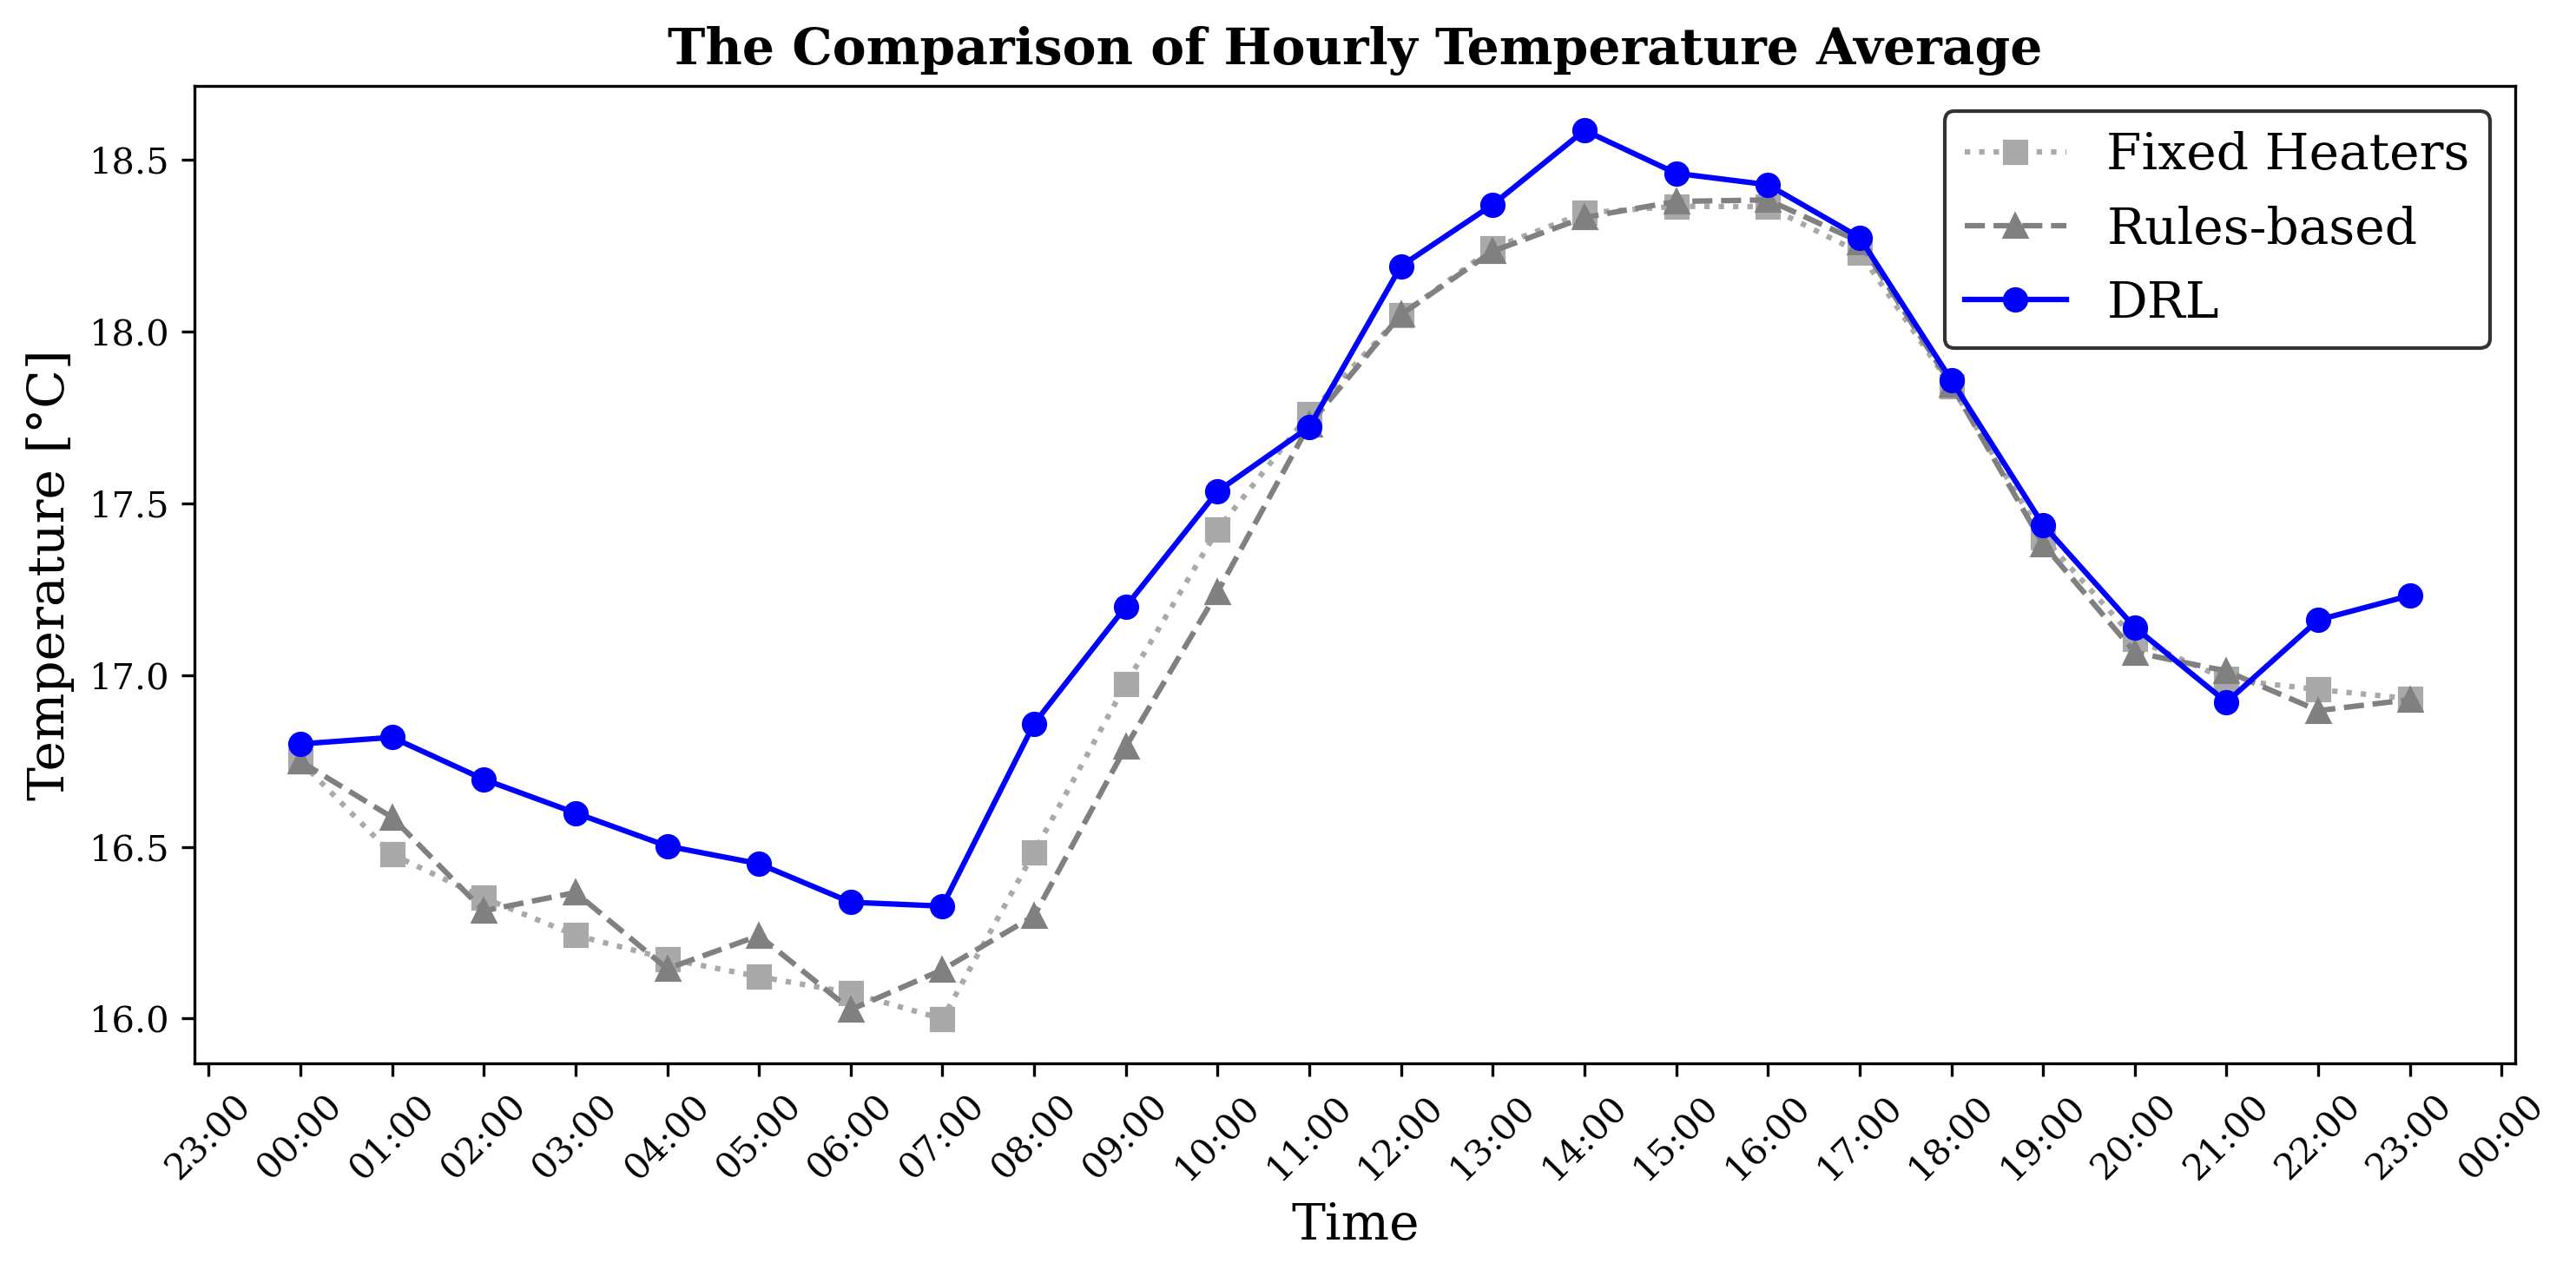

In [31]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Define marker, color, and linestyle mapping for specific types
style_map = {
    "DRL": ("o", "blue", "-"),
    "Rules-based": ("^", "grey", "--"),
    "Fixed Heaters": ("s", "darkgrey", ":")  
}

# Plot each unique type as a separate line
for t in sum_temp_df["type"].unique():
    df_subset = sum_temp_df[sum_temp_df["type"] == t]
    marker, color, linestyle = style_map.get(t, ("*", "black", "-"))  # Defaurb style for unexpected types
    ax.plot(df_subset["datetime"], 
            df_subset["hourly_avg_temp"],  # <-- Changed from 'hourly_std_temp' to 'hourly_avg_temp'
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=t)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Temperature [°C]", fontsize=14)  # Updated Y-axis label
ax.set_title("The Comparison of Hourly Temperature Average", fontsize=14, fontweight='bold')  # Updated title
ax.legend(fontsize=14, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

## Energy Consumption

In [32]:
# Create the energy consumption summary data frame
sum_elec_df = pd.concat([fixed_elec_df, rb_elec_df, drl_elec_df], ignore_index=True)

# Save to the CSV file
sum_elec_df.to_csv("elec_performance_4h.csv", index=False)
# sum_elec_df.to_csv("elec_performance_6h.csv", index=False)
# sum_elec_df.to_csv("elec_performance_8h.csv", index=False)

# Display the data frame
sum_elec_df.info()
sum_elec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date/Time           24 non-null     object        
 1   elec_rate_h1        72 non-null     float64       
 2   elec_rate_h2        72 non-null     float64       
 3   elec_rate_h3        70 non-null     float64       
 4   elec_rate_h4        64 non-null     float64       
 5   Adjusted Date/Time  24 non-null     object        
 6   datetime            72 non-null     datetime64[ns]
 7   total_elec          72 non-null     float64       
 8   type                72 non-null     object        
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 5.2+ KB


,Date/Time,elec_rate_h1,elec_rate_h2,elec_rate_h3,elec_rate_h4,Adjusted Date/Time,datetime,total_elec,type
0,02/28 01:00:00,7.7210,8.2198,7.8868,8.3825,02/28 00:00:00,2023-02-28 00:00:00,32.2101,Fixed Heaters
1,02/28 02:00:00,9.4020,9.8235,9.5275,9.9471,02/28 01:00:00,2023-02-28 01:00:00,38.7001,Fixed Heaters
2,02/28 03:00:00,9.2796,9.5325,9.3436,9.5955,02/28 02:00:00,2023-02-28 02:00:00,37.7512,Fixed Heaters
3,02/28 04:00:00,9.8718,10.0686,9.9139,10.1099,02/28 03:00:00,2023-02-28 03:00:00,39.9642,Fixed Heaters
4,02/28 05:00:00,10.2645,10.4320,10.2970,10.4639,02/28 04:00:00,2023-02-28 04:00:00,41.4574,Fixed Heaters


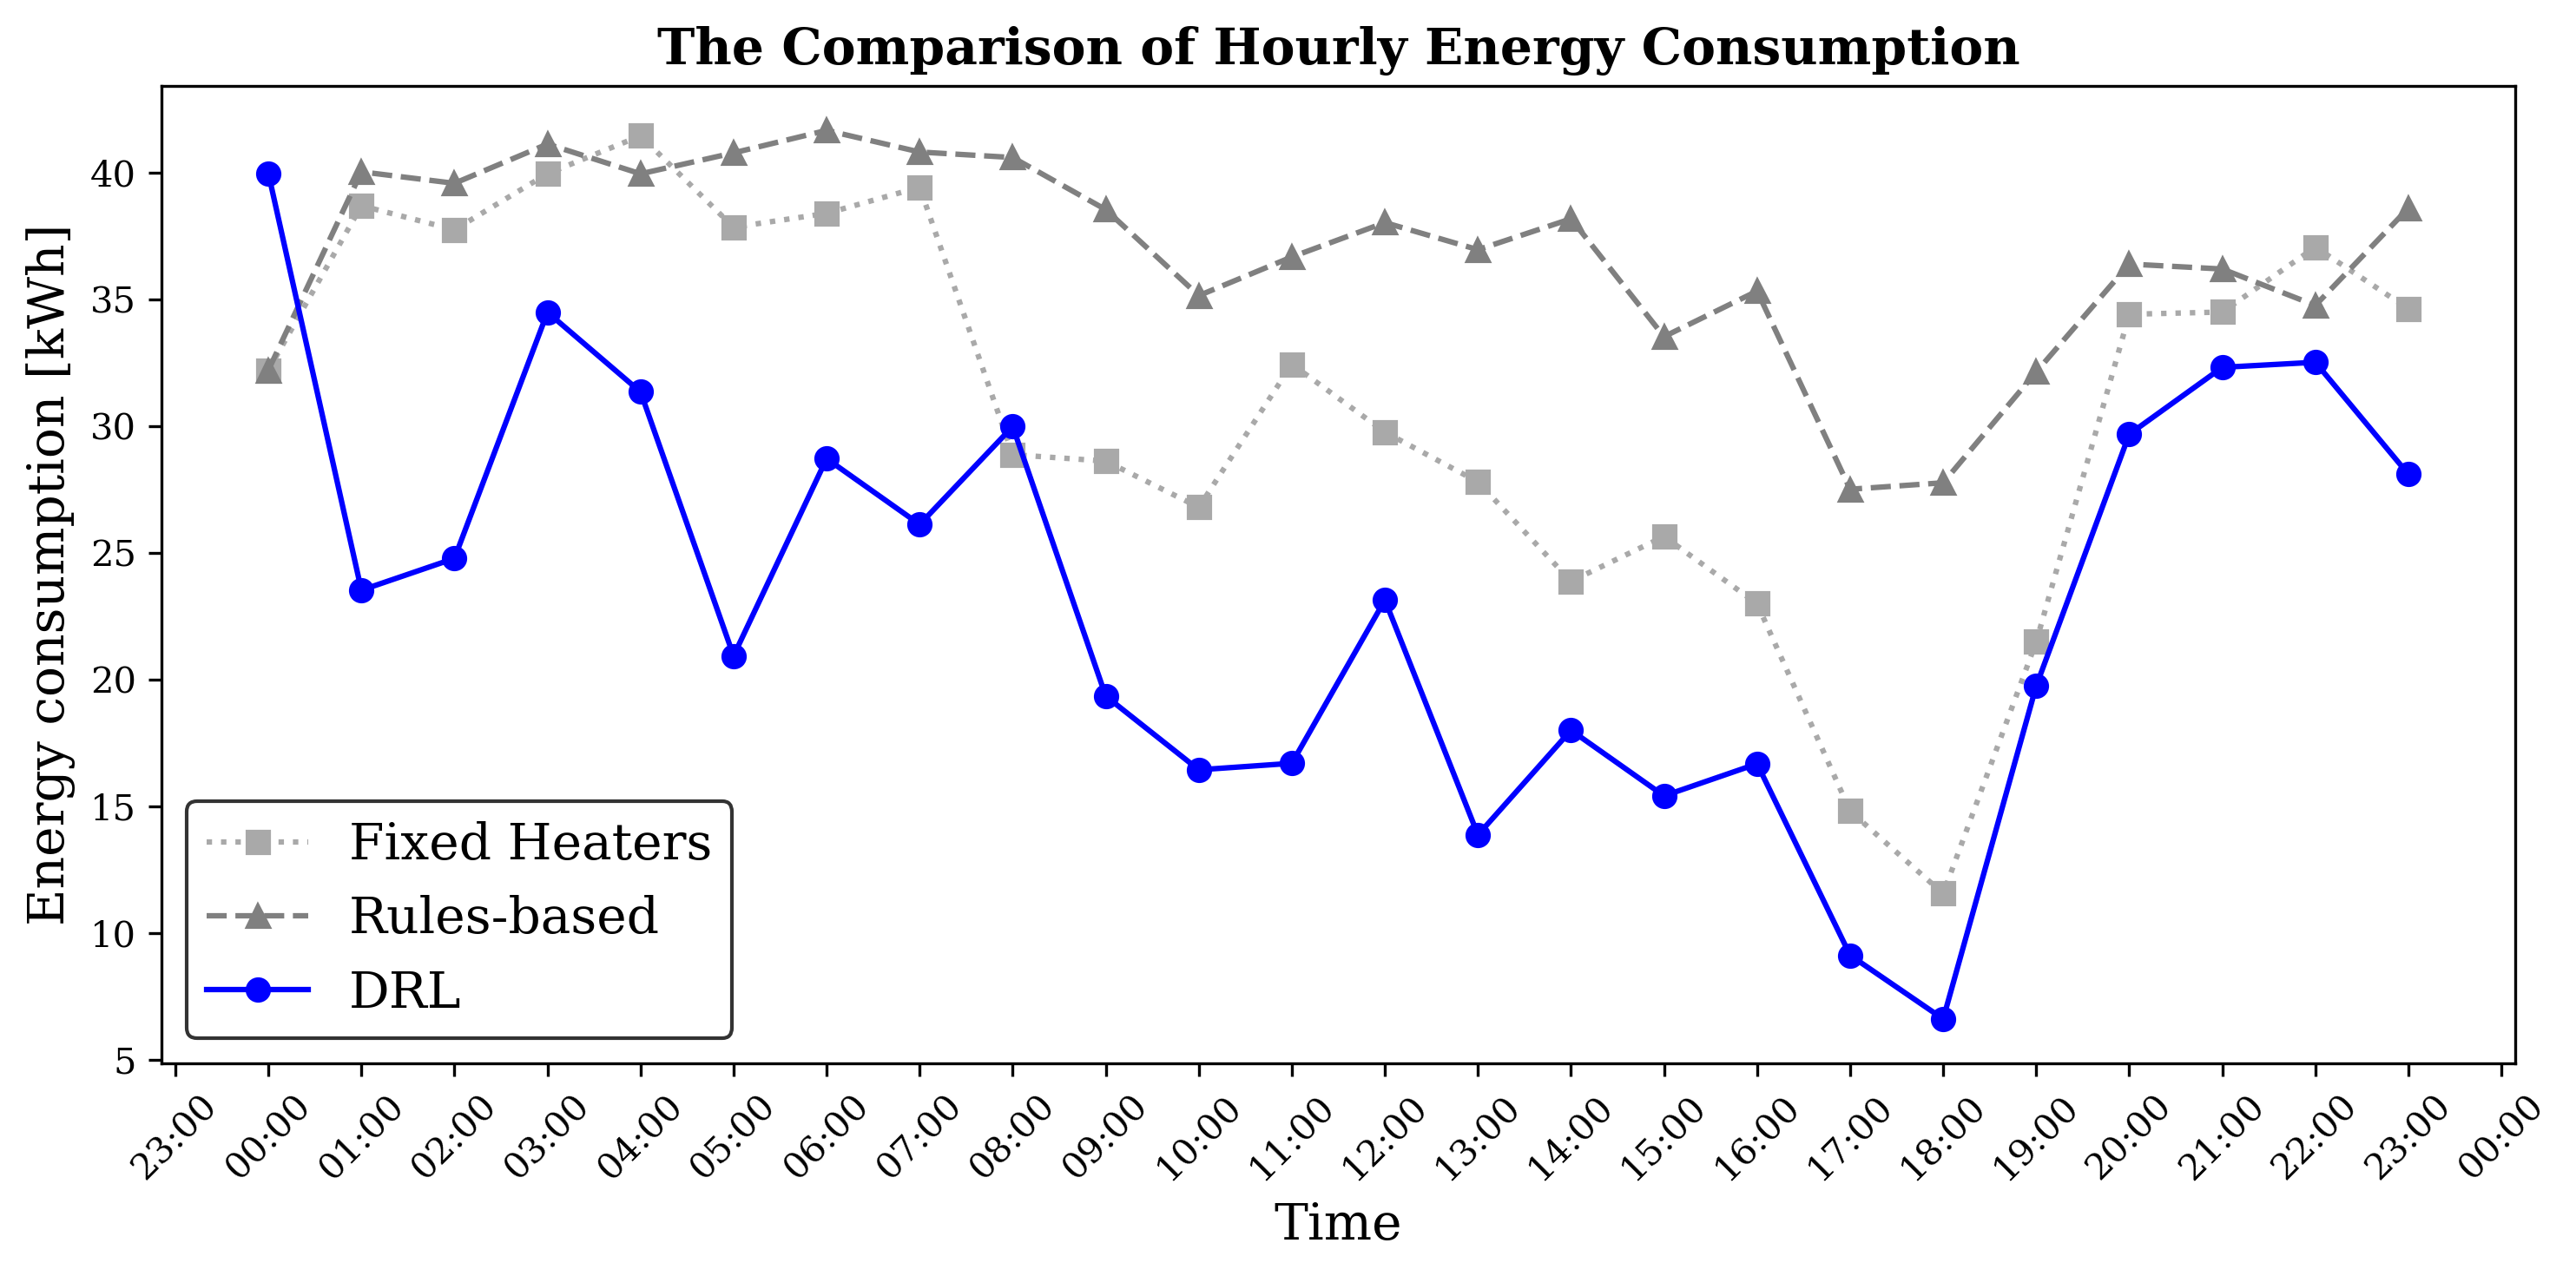

In [33]:
# Set serif font style and explicitly disable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ['Computer Modern Sans Serif']
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Define marker, color, and linestyle mapping for specific types
style_map = {
    "DRL": ("o", "blue", "-"),
    "Rules-based": ("^", "grey", "--"),
    "Fixed Heaters": ("s", "darkgrey", ":")  
}

# Plot each unique type as a separate line
for t in sum_elec_df["type"].unique():
    df_subset = sum_elec_df[sum_elec_df["type"] == t]
    marker, color, linestyle = style_map.get(t, ("*", "black", "-"))  # Defaurb style for unexpected types
    ax.plot(df_subset["datetime"], 
            df_subset["total_elec"],  # <-- Using 'total_elec' as the value
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=t)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Energy consumption [kWh]", fontsize=14)  # Updated Y-axis label
ax.set_title("The Comparison of Hourly Energy Consumption", fontsize=14, fontweight='bold')  # Updated title
ax.legend(fontsize=14, edgecolor='black')

# Show plot
plt.tight_layout()
plt.show()

## Summary table

In [34]:
# Group the data by 'type' and calculate the average of 'hourly_std_temp' and 'hourly_avg_temp'
sum_temp_table = sum_temp_df.groupby('type').agg(avg_hourly_std=('hourly_std_temp', 'mean'), 
                                           avg_hourly_avg=('hourly_avg_temp', 'mean')
                                           ).reset_index()

# Round the calculated averages to 2 decimal places
sum_temp_table = sum_temp_table.round({'avg_hourly_std': 2, 
                                     'avg_hourly_avg': 2})

# Sort the summarized data by 'avg_hourly_std' in ascending order for better visualization
sum_temp_table = sum_temp_table.sort_values(by='avg_hourly_std', 
                                          ascending=True
                                          ).reset_index(drop=True)

# # Show the summarized table
# sum_temp_table

# Group the data by 'type' and calculate the summation of 'total_elec'
sum_elec_table = sum_elec_df.groupby('type').agg(total_elec=('total_elec', 'sum')).reset_index()

# Round the calculated averages to 2 decimal places
sum_elec_table = sum_elec_table.round({'total_elec': 2})

# Sort the summarized data by 'avg_hourly_std' in ascending order for better visualization
sum_elec_table = sum_elec_table.sort_values(by='total_elec', 
                                          ascending=True
                                          ).reset_index(drop=True)

# # Show the summarized table
# sum_elec_table

# Create the summarized table
# Merge the temperature and energy consumption data frame
sum_table = pd.merge(sum_elec_table, sum_temp_table, on="type")

# Display the resulting merged DataFrame
sum_table

,type,total_elec,avg_hourly_std,avg_hourly_avg
0,DRL,557.74,0.73,17.33
1,Fixed Heaters,741.14,0.91,17.15
2,Rules-based,882.63,0.77,17.14
